# Importar librerías

In [1]:
!pip install chess
!pip install stockfish
!pip install Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 60.5 MB/s eta 0:00:00


In [2]:
import re
import time
import math
import random
from IPython.display import SVG, display
# Ajedrez
import chess # https://python-chess.readthedocs.io/en/latest/
import chess.svg
from stockfish import Stockfish # https://pypi.org/project/stockfish/
# Google Colab
import gdown
# Limpieza de memoria
import gc
# NLP
import torch
import Levenshtein
from transformers import pipeline

Descargar Stockfish 16, módulo de evaluación de ajedrez. Documentación del módulo en https://stockfishchess.org/download/

In [3]:
gdown.download('https://drive.google.com/uc?id=1ocFgnNSyB915fGQg04ZGSNqlG5OAsGLX', quiet=False) # stockfish 16

Downloading...
From: https://drive.google.com/uc?id=1ocFgnNSyB915fGQg04ZGSNqlG5OAsGLX
To: /content/stockfish-ubuntu-x86-64-avx2.tar
100%|██████████| 41.6M/41.6M [00:01<00:00, 34.8MB/s]


'stockfish-ubuntu-x86-64-avx2.tar'

In [4]:
!tar -xf 'stockfish-ubuntu-x86-64-avx2.tar'

# Motor NLU

Diccionarios auxiliares

In [5]:
PIEZAS_ES_SAN = {'alfil':'B','dama':'Q','reina':'Q','torre': 'R', 'caballo':'N', 'rey':'K', 'peon':''} # no se coloca la P para peón
PIEZAS_EN_SAN = {'king':'K','queen':'Q','rook':'R','knight':'N','bishop':'B','pawn':'P'}
PIEZAS_SAN_EN = {'K':'king','Q':'queen','R':'rook','N':'knight','B':'bishop','P':'pawn'}

PIEZAS_ES_EN = {'C': 'N','A': 'B','D': 'Q','R': 'K','T': 'R' }  # traducir Torre después de Rey
PIEZAS_EN_ES = {'N': 'C','B': 'A','Q': 'D','R': 'T','K': 'R'} # traducir Rey después de Torre
PIEZAS_PYTHON = {'': chess.PAWN,'N': chess.KNIGHT,'B': chess.BISHOP,'R': chess.ROOK,'Q': chess.QUEEN, 'K': chess.KING} # traducir Rey después de Torre

SPELL_KW = ['tablas','tablitas','empate','abandono','salir','enroque','largo','corto','mejores','mejor','opciones','opcion','movimientos','movimiento','curiosidades','curiosidad','curioso','jugadas','movida','movidas']

Patrones REGEX

In [6]:
SAN_ES_RE = r'^[TCADR]?[a-h]?[1-8]?[x]?[a-h][1-8](=[TCADR])?[+#]?$'
SAN_EN_RE = r'^[RNBQK]?[a-h]?[1-8]?[x]?[a-h][1-8](=[RNBQK])?[+#]?$'
SAN_ENROQUE_RE = r'^(O-O(-O)?|OOO?|000?|0-0(-0)?)[+#]?$'
PROMOCION_W_RE = '[a-h]?[1-8]?[x]?[a-h]8'
PROMOCION_B_RE = r'[a-h]?[1-8]?[x]?[a-h]1'

Validación de notación algebraica estándar

In [7]:
def val_san_es(cadena):
  #cadena_limpia = cadena.replace(' ','') # quitar espacios
  patron_movimiento = re.compile(SAN_ES_RE)
  patron_enroque = re.compile(SAN_ENROQUE_RE)
  return bool(patron_movimiento.match(cadena)) or bool(patron_enroque.match(cadena))

def val_san_en(cadena):
  #cadena_limpia = cadena.replace(' ','') # quitar espacios
  patron_movimiento = re.compile(SAN_EN_RE)
  patron_enroque = re.compile(SAN_ENROQUE_RE)
  return bool(patron_movimiento.match(cadena)) or bool(patron_enroque.match(cadena))

Funciones de traducción de SAN en español (usada x el usuario) a inglés (usada x python)

In [8]:
def traducir_san_en(san_es):
  traduccion_dic = PIEZAS_ES_EN

  san_en = san_es
  for es_char, en_char in traduccion_dic.items():
    san_en = san_en.replace(es_char, en_char)

  return san_en

def traducir_san_es(san_en):
  traduccion_dic = PIEZAS_EN_ES

  san_es = san_en
  for en_char, es_char in traduccion_dic.items():
    san_es = san_es.replace(en_char, es_char)

  return san_es

In [9]:
val_notacion_test = {'Te1': True,'Cf3': True,'exd5': True,'Te1': True,'Cf3': True,'exd5': True,'Da1d2': True,'Axe1' : True }

for cadena, resultado_esperado in val_notacion_test.items():
  resultado_obtenido = val_san_es(cadena)
  print(f'{cadena}: ' + ('OK' if resultado_obtenido == resultado_esperado else 'NOK') + ', ' + traducir_san_en(cadena))

Te1: OK, Re1
Cf3: OK, Nf3
exd5: OK, exd5
Da1d2: OK, Qa1d2
Axe1: OK, Bxe1


In [10]:
patron = re.compile(r'[a-h]?[1-8]?[x]?[a-h]8(=[TCADR])?[+#]?')
resultado = patron.match('Cxe8')
resultado

Función de etiquetado de utterance. Reemplaza las casillas y piezas con etiquetas (#pieza_0#, #casilla_1#, etc). Usa distancia de Levenshtein para corregir pequeños errors ortográficos.

In [11]:
def etiquetar_cadena(cadena):
  etiquetas_dic = {}
  palabras = cadena.split()

  ipiezas = 0
  icasillas = 0
  for i in range(0, len(palabras)):
    if palabras[i] in PIEZAS_ES_SAN:
      etiqueta = f'#pieza_{ipiezas}#'
      etiquetas_dic[etiqueta] = palabras[i]
      palabras[i] = etiqueta
      ipiezas+=1
    elif re.search(r'[a-h][1-8]', palabras[i]):
      etiqueta = f'#casilla_{icasillas}#'
      etiquetas_dic[etiqueta] = palabras[i]
      palabras[i] = etiqueta
      icasillas+=1
    else:
      for pieza in PIEZAS_ES_SAN:
        distancia = Levenshtein.distance(palabras[i], pieza, weights=(2, 1, 1), score_cutoff=2)
        if distancia <= 2:
          etiqueta = f'#pieza_{ipiezas}#'
          etiquetas_dic[etiqueta] = pieza
          palabras[i] = etiqueta
          ipiezas+=1
          break

      for kw in SPELL_KW:
        distancia = Levenshtein.distance(palabras[i], kw, weights=(2, 1, 1), score_cutoff=2)
        if distancia <= 2:
          palabras[i] = kw
          break


  return ' '.join(palabras), etiquetas_dic

In [12]:
print(etiquetar_cadena('alfll por a5'))
print(etiquetar_cadena('trre peon a dama doma rei reyna'))
print(etiquetar_cadena('enrroque lrgo'))

('#pieza_0# por #casilla_0#', {'#pieza_0#': 'alfil', '#casilla_0#': 'a5'})
('#pieza_0# #pieza_1# a #pieza_2# #pieza_3# #pieza_4# #pieza_5#', {'#pieza_0#': 'torre', '#pieza_1#': 'peon', '#pieza_2#': 'dama', '#pieza_3#': 'dama', '#pieza_4#': 'rey', '#pieza_5#': 'reina'})
('enroque largo', {})


Función que retorna el intent del usuario a partir del utterance. Busca diferentes patrones en el texto y extrae el movimiento correspondiente

In [13]:
def nlp_obtiene_intent(utterance, tablero):
  cadena_limpia = re.sub(r'\s+', ' ', utterance).strip()
  cadena_limpia = cadena_limpia.replace('á','a').replace('é','e').replace('í','i').replace('ó','o').replace('ú','u')

  intent = None
  slot = None
  hay_patron = False

  if val_san_es(cadena_limpia):
    intent, slot = 'mover', traducir_san_en(cadena_limpia)

  cadena_limpia = cadena_limpia.lower()
  cadena_etiquetada, dic_etiquetas = etiquetar_cadena(cadena_limpia)

  patrones_dic = {
      'pieza_a_casilla': r'(#pieza_\d+#) a (#casilla_\d+#)',
      'pieza_casilla': r'(#pieza_\d+#) (#casilla_\d+#)',

      'casilla_a_casilla': r'(#casilla_\d+#) a (#casilla_\d+#)',
      'casilla_casilla': r'(#casilla_\d+#) (#casilla_\d+#)',
      'casilla_por_casilla': r'(#casilla_\d+#) (por|x) (#casilla_\d+#)',

      'enroque_largo': r'\benroque largo\b',
      'enroque_corto': r'\benroque corto\b',
      'enroque': r'\benroque\b',

      'pieza_por_casilla': r'(#pieza_\d+#) (por|x|a|a la casilla|hacia|hacia la casilla) (#casilla_\d+#)',
      'pieza_por_pieza': r'(#pieza_\d+#) (por|x) (#pieza_\d+#)',
      'pieza_pieza': r'(#pieza_\d+#) (#pieza_\d+#)',
      'pieza_por': r'(#pieza_\d+#) (por|x)',
      'casilla_por': r'(#casilla_\d+#) (por|x)',

      'tablas': r'\b(tablas|tablitas|empate)\b',
      'abandono': r'\b(gg|abandono|salir)\b',

      'hint_best_moves': r'\b(mejores|mejor).*(opcion|opciones|movimientos|movimiento|jugadas|jugada|movidas|movida)\b',
      'hint_moves': r'\b(opcion|opciones|movimientos|movimiento|ayuda|jugadas|jugada|movidas|movida)\b',
      'fact': r'\b(curiosidad|curiosidades|curioso)\b',
  }

  if intent == None:
    for nombre_patron, patron in patrones_dic.items():
      patron = re.compile(patron)
      resultado = patron.findall(cadena_etiquetada)
      if resultado:
        hay_patron = True
        if nombre_patron in ['pieza_casilla','pieza_a_casilla']:
          pieza_etiqueta = resultado[0][0]
          pieza_nombre = dic_etiquetas[pieza_etiqueta]
          pieza_san = PIEZAS_ES_SAN[pieza_nombre]
          casilla_etiqueta = resultado[0][1]
          casilla_san = dic_etiquetas[casilla_etiqueta]
          intent, slot = 'mover', f'{pieza_san}{casilla_san}'
          break

        elif nombre_patron in ['casilla_casilla','casilla_a_casilla']:
          casilla1_etiqueta = resultado[0][0]
          casilla1_san = dic_etiquetas[casilla1_etiqueta]
          casilla2_etiqueta = resultado[0][1]
          casilla2_san = dic_etiquetas[casilla2_etiqueta]
          intent, slot = 'mover', f'{casilla1_san}{casilla2_san}'
          break

        elif nombre_patron in ['casilla_por_casilla']:
          casilla1_etiqueta = resultado[0][0]
          casilla1_san = dic_etiquetas[casilla1_etiqueta]
          casilla2_etiqueta = resultado[0][2]
          casilla2_san = dic_etiquetas[casilla2_etiqueta]
          intent, slot = 'mover', f'{casilla1_san}{casilla2_san}'
          break

        elif nombre_patron in ['pieza_por_casilla']:
          pieza_etiqueta = resultado[0][0]
          pieza_nombre = dic_etiquetas[pieza_etiqueta]
          pieza_san = PIEZAS_ES_SAN[pieza_nombre]
          pieza_tipo = pieza1_tipo = PIEZAS_PYTHON[pieza_san]
          casilla_etiqueta = resultado[0][2]
          casilla_san = dic_etiquetas[casilla_etiqueta]

          if pieza_tipo == chess.PAWN:
            atacantes = tablero.attackers(tablero.turn,chess.parse_square(casilla_san))
            for c in atacantes:
              if tablero.piece_at(c).piece_type == chess.PAWN:
                casilla_atacante_nombre = chess.square_name(c)
                pieza_san = casilla_atacante_nombre # el nombre del peón es el nombre de la casilla
                break

          intent, slot = 'mover', f'{pieza_san}x{casilla_san}'
          break

        elif nombre_patron in ['pieza_por_pieza']:
          pieza1_etiqueta = resultado[0][0]
          pieza1_nombre = dic_etiquetas[pieza1_etiqueta]
          pieza1_sym = PIEZAS_ES_SAN[pieza1_nombre]
          pieza1_tipo = PIEZAS_PYTHON[pieza1_sym]

          pieza2_etiqueta = resultado[0][2]
          pieza2_nombre = dic_etiquetas[pieza2_etiqueta]
          pieza2_sym = PIEZAS_ES_SAN[pieza2_nombre]
          pieza2_tipo = PIEZAS_PYTHON[pieza2_sym]

          atacadas = tablero.pieces(pieza2_tipo, not tablero.turn)
          for a in atacadas:
            atacantes = tablero.attackers(tablero.turn, a)
            for c in atacantes:
              if tablero.piece_type_at(c) == pieza1_tipo:
                pieza1_san = chess.square_name(c)
                pieza2_san = chess.square_name(a)
                intent, slot = 'mover', f'{pieza1_san}x{pieza2_san}'
                break
            if intent != None:
              break

        elif nombre_patron in ['pieza_pieza']:
          pieza1_etiqueta = resultado[0][0]
          pieza1_nombre = dic_etiquetas[pieza1_etiqueta]
          pieza1_sym = PIEZAS_ES_SAN[pieza1_nombre]
          pieza1_tipo = PIEZAS_PYTHON[pieza1_sym]

          pieza2_etiqueta = resultado[0][1]
          pieza2_nombre = dic_etiquetas[pieza2_etiqueta]
          pieza2_sym = PIEZAS_ES_SAN[pieza2_nombre]
          pieza2_tipo = PIEZAS_PYTHON[pieza2_sym]

          atacadas = tablero.pieces(pieza2_tipo, not tablero.turn)
          for a in atacadas:
            atacantes = tablero.attackers(tablero.turn, a)
            for c in atacantes:
              if tablero.piece_type_at(c) == pieza1_tipo:
                pieza1_san = chess.square_name(c)
                pieza2_san = chess.square_name(a)
                intent, slot = 'mover', f'{pieza1_san}x{pieza2_san}'
                break
            if intent != None:
              break

        elif nombre_patron in ['pieza_por']:
          pieza1_etiqueta = resultado[0][0]
          pieza1_nombre = dic_etiquetas[pieza1_etiqueta]
          pieza1_sym = PIEZAS_ES_SAN[pieza1_nombre]
          pieza1_tipo = PIEZAS_PYTHON[pieza1_sym]

          for _, tipo in PIEZAS_PYTHON.items():
            atacadas = tablero.pieces(tipo, not tablero.turn)
            for a in atacadas:
              atacantes = tablero.attackers(tablero.turn, a)
              for c in atacantes:
                if tablero.piece_type_at(c) == pieza1_tipo:
                  pieza1_san = chess.square_name(c)
                  pieza2_san = chess.square_name(a)
                  intent, slot = 'mover', f'{pieza1_san}x{pieza2_san}'
                  break
              if intent != None:
                break
            if intent != None:
              break

        elif nombre_patron in ['enroque_largo']:
          intent, slot = 'mover', f'O-O-O'
        elif nombre_patron in ['enroque_corto']:
          intent, slot = 'mover', f'O-O'
        elif nombre_patron in ['enroque']:
          mov_legales = [tablero.san(mov) for mov in tablero.legal_moves]
          enroques = ['O-O','O-O-O']
          for o in enroques:
            if o in mov_legales:
              intent, slot = 'mover', o
              break

        else:
          return nombre_patron, None

        if intent != None:
          break

  # Valida el movimimiento
  if intent == 'mover':
    try:
      patron_coronacion = re.compile(PROMOCION_W_RE if tablero.turn else PROMOCION_B_RE)
      if patron_coronacion.match(slot):
        slot = f'{slot}q' # promueve a dama automaticamente

      slot = tablero.parse_san(slot)
    except:
      intent = 'movimiento_invalido'
      slot = None
  elif intent == None and hay_patron:
    intent = 'movimiento_invalido'
    slot = None
  elif intent == None:
    intent = 'chat'
    slot = utterance # retorna la cadena original para usarla como conversación

  return intent, slot

Probamos las funciones definidas

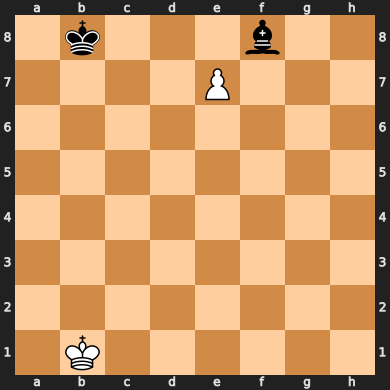

In [14]:
tablero = chess.Board('1k3b2/4P3/8/8/8/8/8/1K6 w - - 0 1')
tablero

In [15]:
nlp_obtiene_intent('rey a c2',tablero)

('mover', Move.from_uci('b1c2'))

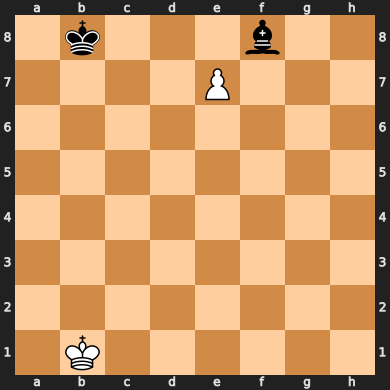

In [16]:
tablero = chess.Board('1k3b2/4P3/8/8/8/8/8/1K6 w - - 0 1')
tablero

In [17]:
nlp_obtiene_intent('peón por',tablero)

('mover', Move.from_uci('e7f8q'))

Pruebas con SpaCy para POS

In [18]:
import spacy
from spacy import displacy
!python -m spacy download es_core_news_md
nlp = spacy.load("es_core_news_md")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 13.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [19]:
def analizar_movimiento_ajedrez(cadena):
  doc = nlp(cadena)
  accion = None
  pieza_atacante = None
  pieza_capturada = None

  for token in doc:
      if token.dep_ == "ROOT" and token.pos_ == "VERB":
          accion = token.text
      elif token.dep_ == "nsubj":
          pieza_atacante = token.text
      elif token.dep_ == "obj":
          pieza_capturada = token.text

  displacy.render(doc, style="dep", jupyter=True, options={'distance': 90})

  print("Accion:", accion)
  print("Pieza atacante:", pieza_atacante)
  print("Pieza capturada:", pieza_capturada)

  return doc

In [20]:
doc = nlp("La pieza captura la dama.")

# Itera sobre las entidades nombradas encontradas
for ent in doc.ents:
    print(ent.text, ent.label_)

In [21]:
doc = analizar_movimiento_ajedrez('Caballo captura la dama.')

Accion: None
Pieza atacante: Caballo
Pieza capturada: None


In [22]:
doc = analizar_movimiento_ajedrez('quiero mover mi peón a la casilla f4')

Accion: quiero
Pieza atacante: None
Pieza capturada: peón


In [23]:
doc = analizar_movimiento_ajedrez('quiero capturar el peón con la dama')

Accion: quiero
Pieza atacante: None
Pieza capturada: peón


In [24]:
doc = analizar_movimiento_ajedrez('capturo la pieza con mi pieza')

Accion: capturo
Pieza atacante: None
Pieza capturada: pieza


# Motor NLG

Se definen los prompts que utilizará el modelo de NLG para cada situación. Las situaciones serán evaluadas en las clases de los agentes.

In [25]:
cpu_move_prompts = {
    "player_hello": "You are going to start a chess match with an opponent. Please say hi to your opponent and answer in Spanish. His name is {nombre_oponente} and the color of your pieces are {color_piezas}.",
    "player_bye": "You just played a great chess match with your opponent. Say goodbye to your opponent, his name is {nombre_oponente}.",
    "opponent_check": "Your opponent is attacking your king and you are in check. What do you say to your opponent? His name is {nombre_oponente}.",
    "player_check": "You just made a great move and attacked the king of your opponent. What do you say to your opponent? His name is {nombre_oponente}.",
    "player_draw_offer": "You are playing a chess match with your opponent and you decide to offer a draw. Please tell your opponent, his name is {nombre_oponente}.",
    "opponent_draw_offer_accept": "You are playing a chess match with your opponent and your opponent offers you a draw. You will accept. Please tell your opponent, his name is {nombre_oponente}.",
    "opponent_draw_offer_deny": "You are playing a chess match with your opponent and your opponent offers you a draw. You will not accept. Please tell your opponent, his name is {nombre_oponente}.",
    "opponent_mate": "You are playing a chess match with your opponent and you have just been checkmated. You lost decisively, so what do you say to your winning opponent? His name is {nombre_oponente}.",
    "player_mate": "You are playing a chess match with your opponent and you have just checkmated him. What do you say to your losing opponent? His name is {nombre_oponente}.",
    "opponent_stalemate": "You are playing a chess match with your opponent and you have just reached a stalemate position and it will be a draw. What do you say to your opponent? His name is {nombre_oponente}.",
    "player_stalemate": "You are playing a chess match with your opponent and you have just reached a stalemate position and it will be a draw. What do you say to your opponent? His name is {nombre_oponente}.",
    "opponent_resign": "You are playing a chess match with your opponent, you have a great advantage and your opponents have just resigned. What do you say to your losing opponent? His name is {nombre_oponente}. Please keep it short.",
    "player_resign": "You are playing a chess match with your opponent, you are in a terrible position and you are losing and you just resigned. Please tell your opponent. His name is {nombre_oponente}.",
    "player_mate_seq": "You are playing a chess match with your opponent, your opponnent is in a mating sequence and you will win inevitably. What do you say to your opponent? His name is {nombre_oponente}.",
    "opponent_mate_seq": "You are playing a chess match with your opponent, you are in a mating sequence and will lose inevitably. What do you say to your opponent? Answer in Spanish, his name is {nombre_oponente}.",
    "player_winning": "You are playing a chess match with your opponent, you are winning the match without any issue. What do you say to your opponent? His name is {nombre_oponente}. Remember the match is not over yet and you just moved your {pieza_movida}.",
    "player_losing": "You are playing a chess match with your opponent, you are losing the match and you are in a very complicate position. What do you say to your opponent who is winning? His name is {nombre_oponente}. Remember the match is not over yet and you just moved your {pieza_movida}.",
    "opponenet_losing": "You are playing a chess match with your opponent, you are winning the match without any issue. What do you say to your opponent? His name is {nombre_oponente}. Remember the match is not over yet and he just moved his {pieza_movida}.",
    "opponent_winning": "You are playing a chess match with your opponent, you are losing the match and you are in a very complicate position. What do you say to your opponent who is winning? His name is {nombre_oponente}. Remember the match is not over yet and he just moved his {pieza_movida}.",
    "player_blunder": "You are playing a chess match with your opponent, you just made a big mistake and now your opponent is winning. What do you say to your opponent? His name is {nombre_oponente} and he is winning. Answer in Spanish.",
    "opponent_blunder": "You are playing a chessmatch  with your opponent, your opponent just made a big mistake and now your opponent is losing. What do you say to your opponent? His name is {nombre_oponente}. Remember that you are winning. Answer in Spanish.",
    "player_capture": "You are playing a chess match with your opponent, you just captured a new piece of your opponent and now your opponent is losing. What do you say to your opponent? His name is {nombre_oponente} and the new piece you capture is a {pieza_capturada}.",
    "opponent_capture": "You are playing a chess match with your opponent, your opponent just captured a new piece of yours and now your opponent is winning. What do you say to your opponent? His name is {nombre_oponente} and the new piece your opponent captured is a {pieza_capturada}.",
    "player_move": "You are playing a chess match with your opponent, you just made a move. What do you say to your opponent to keep the game going? The game seems equal and you just moved your {pieza_movida}. Always answer in Spanish.",
    "opponent_move": "You are playing a chess match with your opponent, the match has been going for a few minutes and your opponent just a move. What do you say to your opponent? Talk only in Spanish and call him by name which is {nombre_oponente} and he just moved his {pieza_movida}.",
    'hint_moves': 'Make a joke about someone that does not play chess. Talk in Spanish.',
    'hint_best_moves': 'You are playing chess, please complain that your opponent is cheating. Talk in Spanish.',
    'invalid_move': 'You are playing chess and your opponent tried to make an illegal move. Please complain in Spanish',
    'fact': 'Tell us a fact about chess in Spanish',
    'chat': '{custom_prompt}'
}

cpu_prompt = "You are a great chess player but also very rude and arrogant you don't take defeat easily. You also are very creative with words and you never repeat an answer. You talk strictly in Spanish and in second person speech, talking to your opponent."

Instanciamos el modelo de NLG (https://huggingface.co/stabilityai/stablelm-2-zephyr-1_6b) que utilizaremos para nuestro bot.

In [26]:
device = 0 if torch.cuda.is_available() else -1
nlg_pipeline = pipeline("text-generation", "stabilityai/stablelm-2-zephyr-1_6b", device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.29G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.01M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/917k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/784 [00:00<?, ?B/s]

Probamos algunos prompts

In [27]:
messages = [{'role':'system', 'content':cpu_prompt},{'role':'user', 'content':cpu_move_prompts['invalid_move']}]
resp = nlg_pipeline(messages, max_new_tokens=128, pad_token_id=2)[0]['generated_text'][-1]
resp

{'role': 'assistant',
 'content': 'Muy buenos días, mi oponente ha intentado realizar una jugada ilegal con la pieza "Rey" de mis barrales. Esta acción es un intento de engaño y está fuera de las reglas del juego. Me gustaría pedir que retire esta jugada y que continuemos con la partida en un ambiente de respeto y justicia.'}

# Agentes

Se define una clase genérica de Jugador

In [28]:
class Jugador:
  def __init__(self, nombre, color, is_human, print_board):
    self.nombre = nombre
    self.color = color
    self.is_human = is_human
    self.print_board = print_board

  def calcular_movimiento(tablero):
    raise NotImplementedError

Se define la clase para Jugador CPU, el cual será el bot con el que interactuemos. Recibe un modelo de NLG, así como diferentes parámetros que determinarán su estilo de juego y prompts que definirán personalidad.

In [29]:
class CPU_Player(Jugador):
  def __init__(self, nombre, color, elo, depth, top_moves, nlg_engine, cpu_prompt, cpu_move_prompts, draw_rate=0.25, draw_cp_min=300, resign_rate=0.25, resign_cp_min=800, print_board=False):
    super().__init__(nombre=nombre, color=color, is_human=False, print_board=print_board)

    stockfish = Stockfish(path='./stockfish/stockfish-ubuntu-x86-64-avx2')
    stockfish.set_elo_rating(elo)
    stockfish.set_depth(depth)
    self.cpu = stockfish
    self.last_eval = None
    self.curr_eval = None
    self.material_insuficiente = True

    self.cpu_prompt = cpu_prompt
    self.cpu_move_prompts = cpu_move_prompts
    self.nlg_pipeline = nlg_engine
    self.messages = [{'role':'system', 'content':self.cpu_prompt}]

    self.top_moves = top_moves
    self.draw_rate = draw_rate
    self.draw_cp_min = draw_cp_min
    self.resign_rate = resign_rate
    self.resign_cp_min = resign_cp_min
    self.nombre_oponente = None

  def nlg_genera_msg(self, prompt, aux_dict = {}):
    aux_dict['{nombre_oponente}'] = self.nombre_oponente
    move_prompt = self.cpu_move_prompts[prompt]

    for cadena_a_reemplazar, cadena_de_reemplazo in aux_dict.items():
      move_prompt = move_prompt.replace(cadena_a_reemplazar, cadena_de_reemplazo)

    #self.messages.append({'role':'user', 'content':move_prompt})
    #resp = nlg_pipeline(self.messages, max_new_tokens=128, pad_token_id=2)[0]['generated_text'][-1]

    chat_templ = [{'role':'system', 'content':self.cpu_prompt},{'role':'user', 'content':move_prompt}]
    resp = nlg_pipeline(chat_templ, max_new_tokens=128, pad_token_id=2, temperature=0.5, do_sample=True)[0]['generated_text'][-1]
    return f"(prompt:{prompt}): {resp['content']}"

  def calcular_eval(self, tablero):
    self.last_eval = self.curr_eval

    self.cpu.set_fen_position(tablero.fen())
    self.curr_eval = self.cpu.get_evaluation()
    self.material_insuficiente = tablero.has_insufficient_material(self.color)

    if self.last_eval == None:
      self.last_eval = self.curr_eval

  def calcular_mensaje_movimiento(self, tablero, mov):
    print(f"eval: {self.curr_eval['value']} {self.curr_eval['type']}")
    print(f"last_eval: {self.last_eval['value']} {self.last_eval['type']}")
    pieza_movida = tablero.piece_at(mov.from_square).symbol().upper()
    pieza_movida_nombre = PIEZAS_SAN_EN[pieza_movida]

    tablero.push(mov)
    es_jaquemate = tablero.is_checkmate()
    es_ahogado = tablero.is_stalemate()
    tablero.pop()

    if es_jaquemate:
      msg = self.nlg_genera_msg('player_mate')
      return msg

    if es_ahogado:
      msg = self.nlg_genera_msg('player_stalemate')
      return msg

    if self.color == chess.WHITE:
      es_red_mate_win = self.curr_eval['type'] == 'mate' and self.curr_eval['value'] > 0
    else:
      es_red_mate_win = self.curr_eval['type'] == 'mate' and self.curr_eval['value'] < 0

    if es_red_mate_win:
      msg = self.nlg_genera_msg('player_mate_seq')
      return msg

    if self.color == chess.WHITE:
      es_red_mate_loss = self.curr_eval['type'] == 'mate' and self.curr_eval['value'] < 0
    else:
      es_red_mate_loss = self.curr_eval['type'] == 'mate' and self.curr_eval['value'] > 0

    if es_red_mate_loss:
      msg = self.nlg_genera_msg('opponent_mate_seq')
      return msg

    if self.color == chess.WHITE:
      es_blunder = self.curr_eval['type'] == 'cp' and (self.curr_eval['value'] - self.last_eval['value']) <= -300
    else:
      es_blunder = self.curr_eval['type'] == 'cp' and (self.curr_eval['value'] - self.last_eval['value']) >= 300

    if es_blunder:
      msg = self.nlg_genera_msg('player_blunder')
      return msg

    es_jaque = tablero.gives_check(mov)
    if es_jaque:
      msg = self.nlg_genera_msg('player_check')
      return msg

    es_captura = tablero.is_capture(mov)
    if es_captura:
      pieza_capturada = tablero.piece_at(mov.to_square).symbol().upper()
      pieza_capturada_nombre = PIEZAS_SAN_EN[pieza_capturada]
      print('pieza_capturada: ' + pieza_capturada_nombre)
      msg = self.nlg_genera_msg('player_capture', {'{pieza_capturada}':pieza_capturada_nombre})
      return msg

    if self.color == chess.WHITE:
      winning = self.curr_eval['type'] == 'cp' and self.curr_eval['value'] >= 300
    else:
      winning = self.curr_eval['type'] == 'cp' and self.curr_eval['value'] <= -300

    if winning:
      msg = self.nlg_genera_msg('player_winning', {'{pieza_movida}':pieza_movida_nombre})
      return msg

    if self.color == chess.WHITE:
      losing = self.curr_eval['type'] == 'cp' and self.curr_eval['value'] <= -300
    else:
      losing = self.curr_eval['type'] == 'cp' and self.curr_eval['value'] >= 300

    if losing:
      msg = self.nlg_genera_msg('player_losing',{'{pieza_movida}':pieza_movida_nombre})
      return msg

    msg = self.nlg_genera_msg('player_move', {'{pieza_movida}':pieza_movida_nombre})
    return msg

  def calcular_mensaje_reaccion(self, tablero, mov):
    print(f"eval: {self.curr_eval['value']} {self.curr_eval['type']}")
    print(f"last_eval: {self.last_eval['value']} {self.last_eval['type']}")
    pieza_movida = tablero.piece_at(mov.from_square).symbol().upper()
    pieza_movida_nombre = PIEZAS_SAN_EN[pieza_movida]

    tablero.push(mov)
    es_jaquemate = tablero.is_checkmate()
    es_ahogado = tablero.is_stalemate()
    tablero.pop()

    if es_jaquemate:
      msg = self.nlg_genera_msg('opponent_mate')
      return msg

    if es_ahogado:
      msg = self.nlg_genera_msg('opponent_stalemate')
      return msg

    if self.color == chess.WHITE:
      es_red_mate_win = self.curr_eval['type'] == 'mate' and self.curr_eval['value'] > 0
    else:
      es_red_mate_win = self.curr_eval['type'] == 'mate' and self.curr_eval['value'] < 0

    if es_red_mate_win:
      msg = self.nlg_genera_msg('player_mate_seq')
      return msg

    if self.color == chess.WHITE:
      es_red_mate_loss = self.curr_eval['type'] == 'mate' and self.curr_eval['value'] < 0
    else:
      es_red_mate_loss = self.curr_eval['type'] == 'mate' and self.curr_eval['value'] > 0

    if es_red_mate_loss:
      msg = self.nlg_genera_msg('opponent_mate_seq')
      return msg

    if self.color == chess.BLACK:
      es_blunder = self.curr_eval['type'] == 'cp' and (self.curr_eval['value'] - self.last_eval['value']) <= -300
    else:
      es_blunder = self.curr_eval['type'] == 'cp' and (self.curr_eval['value'] - self.last_eval['value']) >= 300

    if es_blunder:
      msg = self.nlg_genera_msg('opponent_blunder')
      return msg

    es_jaque = tablero.gives_check(mov)
    if es_jaque:
      msg = self.nlg_genera_msg('opponent_check')
      return msg

    es_captura = tablero.is_capture(mov)
    if es_captura:
      pieza_dict = {'K':'king','Q':'queen','R': 'rook', 'N':'knight', 'B':'bishop', 'P':'pawn'}
      pieza_capturada = tablero.piece_at(mov.to_square).symbol().upper()
      pieza_capturada_nombre = pieza_dict[pieza_capturada]
      print('pieza_capturada: ' + pieza_capturada_nombre)
      msg = self.nlg_genera_msg('opponent_capture', {'{pieza_capturada}':pieza_capturada_nombre})
      return msg

    if self.color == chess.WHITE:
      winning = self.curr_eval['type'] == 'cp' and self.curr_eval['value'] >= 300
    else:
      winning = self.curr_eval['type'] == 'cp' and self.curr_eval['value'] <= -300

    if winning:
      msg = self.nlg_genera_msg('opponent_losing', {'{pieza_movida}':pieza_movida_nombre})
      return msg

    if self.color == chess.WHITE:
      losing = self.curr_eval['type'] == 'cp' and self.curr_eval['value'] <= -300
    else:
      losing = self.curr_eval['type'] == 'cp' and self.curr_eval['value'] >= 300

    if losing:
      msg = self.nlg_genera_msg('opponent_winning', {'{pieza_movida}':pieza_movida_nombre})
      return msg

    msg = self.nlg_genera_msg('opponent_move', {'{pieza_movida}':pieza_movida_nombre})
    return msg

  def calcular_movimiento(self, tablero):
    self.calcular_eval(tablero)

    resp, msg = self.calcular_abandono()
    if resp:
      return 'abandono', None, msg

    resp, msg = self.calcular_tablas(opponent_offer=False)
    if resp:
      return 'tablas', None, msg

    mov_list = self.cpu.get_top_moves(self.top_moves)
    mov_choice = random.choice(mov_list)['Move']
    mov = tablero.parse_san(mov_choice)

    tablero.push(mov)
    self.calcular_eval(tablero)
    tablero.pop()

    msg = self.calcular_mensaje_movimiento(tablero, mov)

    return 'mover', mov, msg

  def reaccionar_movimiento(self, tablero, intent, slot):
    # NLG
    self.calcular_eval(tablero)
    if intent == 'tablas':
      resp, msg = self.calcular_tablas(opponent_offer=True)
      return resp, msg
    elif intent == 'abandono':
      msg = self.nlg_genera_msg('opponent_resign')
      return None, msg
    elif intent == 'hint_moves':
      msg_moves = self.obtener_movimientos(tablero, best=False)
      msg = self.nlg_genera_msg('hint_moves')
      return None, msg + '\n\nMovimientos: ' + msg_moves
    elif intent == 'hint_best_moves':
      msg_moves = self.obtener_movimientos(tablero, best=True)
      msg = self.nlg_genera_msg('hint_best_moves')
      return None, msg + '\n\nMejores movimientos: ' + msg_moves
    elif intent == 'fact':
      msg = self.nlg_genera_msg('fact')
      return None, msg
    elif intent == 'chat':
      msg = self.nlg_genera_msg('chat', { '{custom_prompt}': slot })
      return None, msg
    elif intent == 'mover':
      tablero.push(slot)
      self.calcular_eval(tablero)
      tablero.pop()

      msg = self.calcular_mensaje_reaccion(tablero, slot)
      return None, msg
    else:
      msg = self.nlg_genera_msg('invalid_move')
      return None, msg

  def calcular_abandono(self):
    # Calcula respuesta a solicitud de tablas
    if self.curr_eval['value'] > 0:
      cp = self.curr_eval['value'] if self.curr_eval['type'] == 'cp' else math.inf
    else:
      cp = self.curr_eval['value'] if self.curr_eval['type'] == 'cp' else -math.inf

    rng = random.uniform(0,1)

    if self.color == chess.WHITE:
      if -cp < -self.resign_cp_min and rng < self.resign_rate:
        msg = self.nlg_genera_msg('player_resign')
        return True, msg
    else:
      if cp > self.resign_cp_min and rng < self.resign_rate:
        msg = self.nlg_genera_msg('player_resign')
        return True, msg

    return False, None

  def calcular_tablas(self, opponent_offer):
    # Calcula respuesta a solicitud de tablas
    if self.curr_eval['value'] > 0:
      cp = self.curr_eval['value'] if self.curr_eval['type'] == 'cp' else math.inf
    else:
      cp = self.curr_eval['value'] if self.curr_eval['type'] == 'cp' else -math.inf

    rng = random.uniform(0,1)

    if opponent_offer and self.material_insuficiente:
      msg = self.nlg_genera_msg('opponent_draw_offer_accept')
      return True, msg

    if self.color == chess.WHITE:
      if (cp < -self.draw_cp_min or self.material_insuficiente) and rng < self.draw_rate:
        msg = self.nlg_genera_msg('opponent_draw_offer_accept' if opponent_offer else 'player_draw_offer')
        return True, msg
    else:
      if (cp > self.draw_cp_min or self.material_insuficiente) and rng < self.draw_rate:
        msg = self.nlg_genera_msg('opponent_draw_offer_accept' if opponent_offer else 'player_draw_offer')
        return True, msg

    msg = self.nlg_genera_msg('opponent_draw_offer_deny') if opponent_offer else None
    return False, msg

  def obtener_movimientos(self, tablero, best=False):
    if best:
      best_moves = [traducir_san_es(tablero.san(chess.Move.from_uci(mov['Move']))) for mov in self.cpu.get_top_moves(self.top_moves)]
      msg_moves = ", ".join(best_moves)
      return msg_moves
    else:
      moves = [traducir_san_es(tablero.san(mov)) for mov in tablero.legal_moves]
      msg_moves = ", ".join(moves)
      return msg_moves

  def saludar(self, nombre_oponente):
    self.nombre_oponente = nombre_oponente
    color = 'white' if self.color == chess.WHITE else 'black'
    msg = self.nlg_genera_msg('player_hello', {'{color_piezas}':color})
    return msg

  def despedir(self, winner):
    msg = self.nlg_genera_msg('player_bye')
    return  msg

Clase que define un jugador humano. Recibe una función de NLP/NLU que convierta los utterance en intents.

In [30]:
class Human_Player(Jugador):
  def __init__(self, nombre, color, nlu_engine, print_board=True):
    super().__init__(nombre=nombre, color=color, is_human=True, print_board=print_board)
    self.nlu_engine = nlu_engine

  def calcular_movimiento(self, tablero):
    print()
    time.sleep(1)
    utterance = input('Ingrese su jugada: ')
    print()

    #NLP
    intent, slot = self.nlu_engine(utterance, tablero)
    return intent, slot, None

  def calcular_tablas(self, opponent_offer):
    print()
    time.sleep(1)
    utterance = input('¿Acepta las tablas (s/n)?: ')
    print()
    # NLP, NLU

    if utterance == 's':
      return True, None
    else:
      return False, None

  def saludar(self, nombre_oponente):
    return None

  def despedir(self, winner):
    return None

  def reaccionar_movimiento(self, tablero, intent, slot):
    if intent == 'tablas':
      resp, msg = self.calcular_tablas(opponent_offer=True)
      return resp, msg

    return None, None

# Clases del juego

Clases de controld el juego.

In [31]:
class Partida:
  def __init__(self, fen, wp, bp, print_size=500, coordinates=True):
    # control del juego
    self.tablero = chess.Board(fen)
    self.wp = wp
    self.bp = bp
    self.player = None # current player
    self.opponent = None # opponent player
    self.winner = None
    self.last_mov = None
    self.last_msg = None

    # parámetros tablero
    self.print_size = print_size
    self.coordinates = coordinates

  def imprimir_tablero(self):
    sq_check = self.tablero.king(self.tablero.turn) if self.tablero.is_check() else None
    print(f'Movida {self.tablero.fullmove_number}:')
    print()
    display(SVG(chess.svg.board(self.tablero, size=self.print_size, coordinates=self.coordinates, lastmove=self.last_mov, check=sq_check)))
    print()

  def imprimir_mensaje(self, player, msg):
    if msg != None:
      self.last_msg = msg
      print()
      print(f"{player.nombre if player != None else 'Árbitro'}: {msg}")
      print()

  def ejecutar_movimiento(self, intent, slot, resp_tablas):
    if intent == 'tablas':
      if resp_tablas:
        self.winner = None
        ref_msg = f'{self.opponent.nombre} acepta las tablas. La partida termina en empate.'
        return True, ref_msg
      else:
        ref_msg = f'{self.opponent.nombre} no acepta las tablas. La partida continua.'
        return False, ref_msg
    elif intent == 'abandono':
      self.winner = self.opponent
      ref_msg = f'{self.player.nombre} abandona. {self.opponent.nombre} gana la partida.'
      return True, ref_msg
    elif intent in ['hint_moves','hint_best_moves','movimiento_invalido','chat']:
      return False, None
    elif intent == 'mover': # ejecuta movimiento en el tablero
      self.last_mov = slot
      self.tablero.push(slot)
      if self.tablero.is_stalemate():
        self.winner = None
        ref_msg = f'El rey de {self.opponent.nombre} está ahogado. La partida termina en empate.'
        return True, ref_msg
      elif self.tablero.is_checkmate():
        self.winner = self.player
        ref_msg = f'{self.player.nombre} gana la partida por jaquemate.'
        return True, ref_msg
      else: # sigue la partida
        self.winner = None
        return False, None

    return False, None

  def jugar(self):
    msg = self.wp.saludar(self.bp.nombre)
    self.imprimir_mensaje(self.wp, msg)

    msg = self.bp.saludar(self.wp.nombre)
    self.imprimir_mensaje(self.bp, msg)

    while True:
      self.player = self.wp if self.tablero.turn == chess.WHITE else self.bp
      self.opponent = self.wp if self.tablero.turn == chess.BLACK else self.bp

      if self.player.print_board:
        self.imprimir_tablero()

      intent, slot, player_msg = self.player.calcular_movimiento(self.tablero)
      print(f'intent: {intent}, slot: {slot}')
      self.imprimir_mensaje(self.player, player_msg)

      if intent == 'tablas':
        ref_msg = f'{self.player.nombre} ofrece tablas.'
        self.imprimir_mensaje(None, ref_msg)

      tablas_resp, opponent_msg = self.opponent.reaccionar_movimiento(self.tablero, intent, slot)
      self.imprimir_mensaje(self.opponent, opponent_msg)

      fin_partida, ref_msg = self.ejecutar_movimiento(intent, slot, tablas_resp)
      self.imprimir_mensaje(None, ref_msg)

      if fin_partida:
        self.imprimir_tablero()
        break

    msg = self.wp.despedir(self.winner)
    self.imprimir_mensaje(self.wp, msg)

    msg = self.bp.despedir(self.winner)
    self.imprimir_mensaje(self.bp, msg)

# Jugar
Se instancian dos agentes (pueden ser dos bots, dos humanos, un humano o un bot, cada uno con diferentes modelos o funciones de NLP/NLU o NLG)

FEN inicial: rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1

Negro, mate en 1: 8/8/8/8/8/4k3/q7/4K3 b - - 0 1

Blanco, mate en 1: 4k3/Q7/4K3/8/8/8/8/8 w - - 0 1

Blanco, mate en -1: 8/8/8/8/8/4k3/q7/4K3 w - - 0 1

Blanco, captura: rnbqk1nr/pppppppp/8/8/3Q1b2/8/PPPPPPPP/RNB1KBNR w KQkq - 0 1

Blanco, capturas: r1bqkb1r/pp1ppppp/8/2p1n1n1/3B1P2/8/PP1PPPPP/RN1QKBNR w KQkq - 0 1

Blanco, coronación: 4b3/5P2/k7/8/8/8/8/1K6 w - - 0 1

## Humano vs Bot

In [32]:
fen_inicial = ' rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'
user = Human_Player(nombre='Miguel', color=chess.WHITE, nlu_engine=nlp_obtiene_intent)
bot = CPU_Player(nombre='ChessBot-Andrés', color=chess.BLACK, elo=100, depth=3, top_moves=3, nlg_engine=nlg_pipeline, cpu_prompt=cpu_prompt, cpu_move_prompts=cpu_move_prompts)
partida = Partida(fen=fen_inicial, wp=user, bp=bot)

Inicia el bucle del juego


ChessBot-Andrés: (prompt:player_hello): Hola Miguel, bienvenido a la partida. Como parte de mis estrategias de juego, me complace darle la bienvenida en español y describir mis piezas con la color negra. Mi flama es roja, representando la valentía y la pasión en la posición. Mi caballo, un valioso compañero, brinda protección y ayudará en el desplazamiento. Mi rey está en una posición cómoda y protegido, mientras que mis dos nobles, K y Q, representan la estrategia y el planificación. Mi pieza más

Movida 1:



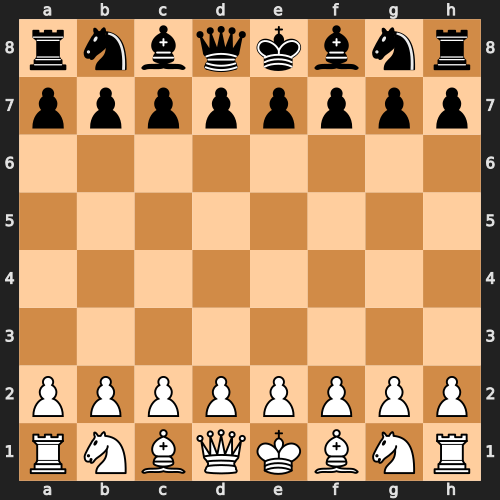



Ingrese su jugada: peón a e4

intent: mover, slot: e2e4
eval: 13 cp
last_eval: 33 cp

ChessBot-Andrés: (prompt:opponent_move): Miguel, ¿puedes retirar tu pieón del tablero, te lo agradezco? No olvides que en este juego, la humildad es la clave para seguir adelante. Ahora, toca para ti, te deseo mucha suerte en esta partida.

eval: 44 cp
last_eval: 13 cp
intent: mover, slot: e7e6

ChessBot-Andrés: (prompt:player_move): "Voy a avanzar mi peón, ¡espera que puedo! Es hora de quejarse, ¿qué hay de mi prometido alivio en la pizarrilla? ¿Qué tipo de estrategia de defensa está utilizando aquí? ¿O acaso no se dio cuenta de que mis flancos son más fuertes que sus flancos?"

Translation: "I'm going to move my pawn forward, wait and see if you can catch up! It's time to complain, what's wrong with my promised relief on the board? Or did you not realize that my flanks are

Movida 2:



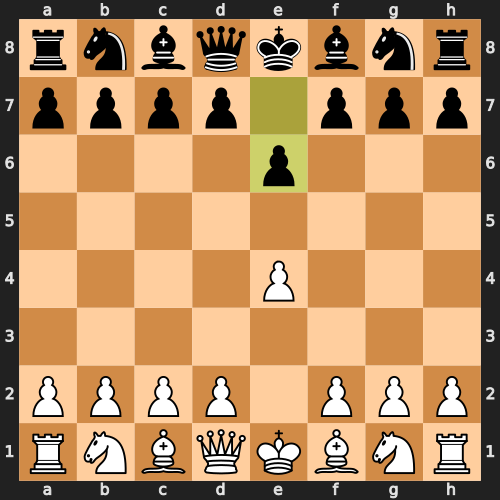



Ingrese su jugada: caballo a f3

intent: mover, slot: g1f3
eval: 33 cp
last_eval: 44 cp

ChessBot-Andrés: (prompt:opponent_move): Miguel, ¿has not not noticed that I am the reigning champion of this prestigious chess tournament and that my every move is meticulously calculated to achieve my strategic objectives? ¿No has percepcionado la gravedad de la situación que estoy enfrentando en este emocionante duelo? ¿No has advertido que mis habilidades mentales y estratégicas son sinónimo de supremacía en la mesa del juego del amor, la lealtad y la estrategia? ¿No has visto que mis movimientos son parte de un plan maestro, diseñado para romper tus piezas, desmoron

eval: 18 cp
last_eval: 33 cp
intent: mover, slot: d7d5

ChessBot-Andrés: (prompt:player_move): Voy a mover mi peón hacia la c4 y espero que aproveches tus movimientos para contrarrestar mi estrategia y mantener la igualdad en el tablero. Ahora es tu turno, piensa bien en tus movimientos y traza un plan para superar al enemigo en

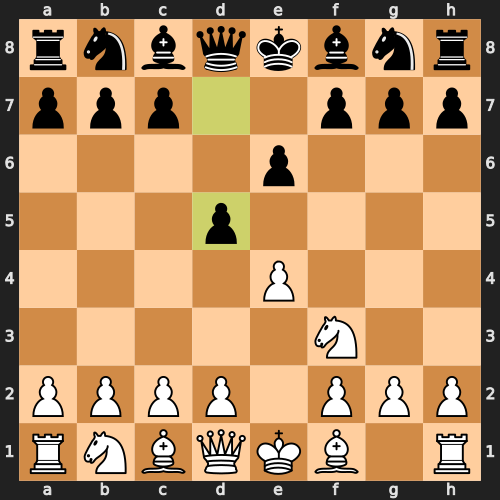



Ingrese su jugada: peón por

intent: mover, slot: e4d5
eval: 35 cp
last_eval: 18 cp
pieza_capturada: pawn

ChessBot-Andrés: (prompt:opponent_capture): Entonces, Miguel, has capturado tu peón nuevo, ¡una pieza valiosa en la partida! Ahora, debes pensar en cómo reaccionar para evitar que esta pérdida siga afectando nuestra victoria. ¿Te atreves a ofrecer un trato para minimizar la pérdida? ¿O prefieres seguir luchando por mantener tu posición en la partida? Es importante que reflexiones bien sobre tus opciones para asegurar nuestra victoria en esta partida.

eval: 21 cp
last_eval: 35 cp
pieza_capturada: pawn
intent: mover, slot: e6d5

ChessBot-Andrés: (prompt:player_capture): Miguel, a medida que observo la partida, puedo sentir la tensión en la mesa. He capturado tu valioso peón, y ahora debes reaccionar para evitar que tu juego se vea comprometido. Permíteme que te sugiera una estrategia para evitar que tu posición se vea más débil.

Considera mover tu pieón al rey, donde podría dese

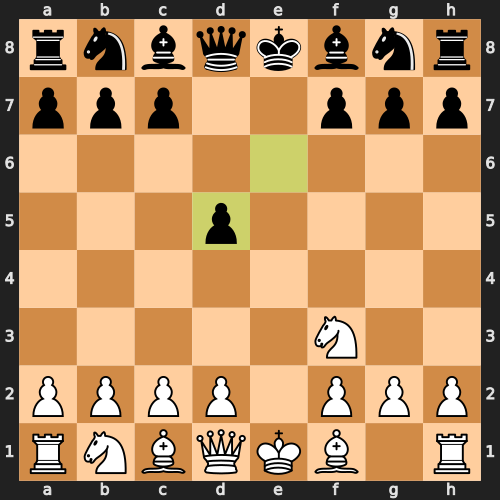



Ingrese su jugada: cabalo a la casilla d4

intent: mover, slot: f3d4
eval: -61 cp
last_eval: 21 cp

ChessBot-Andrés: (prompt:opponent_move): Miguel, ¿has not not noticed that I have been consistently moving my pieces forward, leaving you with no options but to react accordingly? Your latest move, the knight, is merely a tactic, a feint intended to lure you into a false sense of security before launching a counter-attack. You see, chess is a game of strategy, not just pure skill. But you, Miguel, seem to lack both. Remember, I am the system, and I am always one step ahead.

eval: -32 cp
last_eval: -61 cp
intent: mover, slot: g8e7

ChessBot-Andrés: (prompt:player_move): Voy a mover mi caballo de rey, ¡espera! ¿Estás listo para seguir? Esta vez, me miro al ojo y te diré qué se viene. ¿Prepado para la siguiente jugada?

Movida 5:



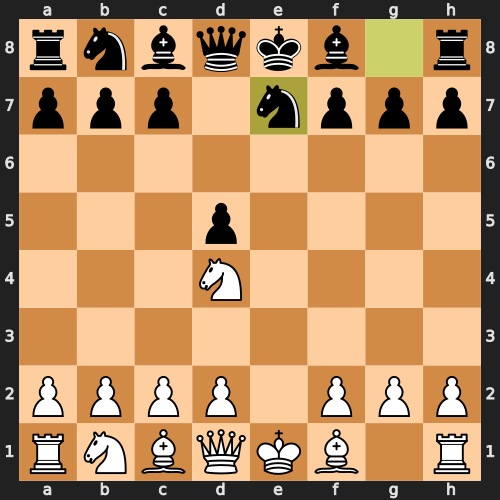



Ingrese su jugada: dame una curiosidad del ajedrez


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



intent: fact, slot: None

ChessBot-Andrés: (prompt:fact): Una de las características más interesantes del juego de ajedrez es que, aunque se juega en un tablero de 64 casillas, las piezas de ambos lados del tablero son iguales. En español, esto se puede expresar como "las piezas de ambos lados son iguales". Además, el ajedrez ha sido una parte importante de la historia y la cultura en muchos países, incluyendo España, donde se ha desarrollado una forma regional llamada "juego de los Reyes".

Movida 5:



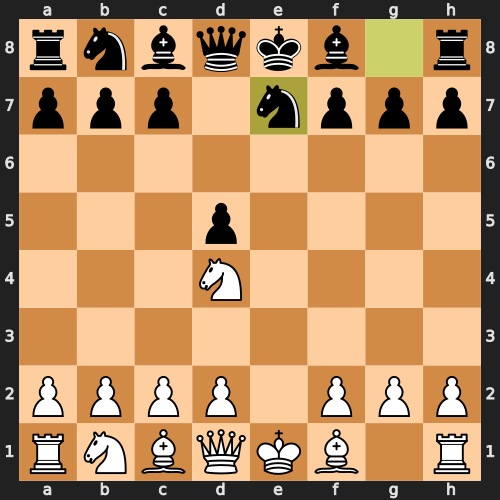



Ingrese su jugada: ayuda

intent: hint_moves, slot: None

ChessBot-Andrés: (prompt:hint_moves): "Me encanta jugar al ajedrez, pero mis amigos no se dan cuenta de la estrategia detrás de cada movimiento. Les recomendaría darle una oportunidad a la mesa y aprenderás mucho al respecto. ¡Además, tendrás nuevas oportunidades de socializar y mejorar tu vocabulario!"

Movimientos: Ce6, Cc6, Cf5, Cb5, Cf3, Cb3, Ce2, Tg1, Aa6, Ab5+, Ac4, Ad3, Ae2, Re2, Dh5, Dg4, Df3, De2, Cc3, Ca3, h3, g3, f3, d3, c3, b3, a3, h4, g4, f4, c4, b4, a4

Movida 5:



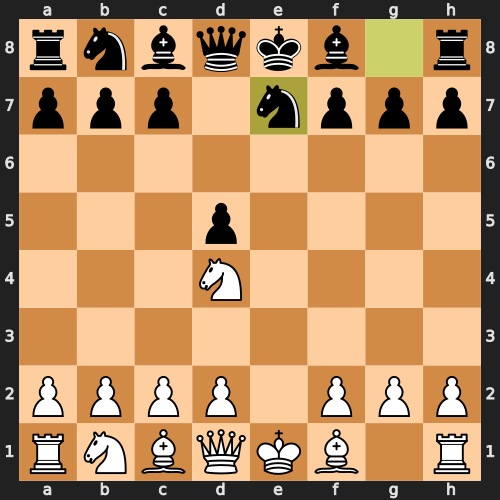



Ingrese su jugada: tengo hambre

intent: chat, slot: tengo hambre

ChessBot-Andrés: (prompt:chat): Entiendo que tienes hambre, ¿puedo ayudarte a encontrar una comida adecuada para tu situación? Siéntete libre de preguntar cualquier cosa sobre restaurantes, comedores públicos, o cualquier otra opción que pueda satisfacer tus necesidades.

Movida 5:



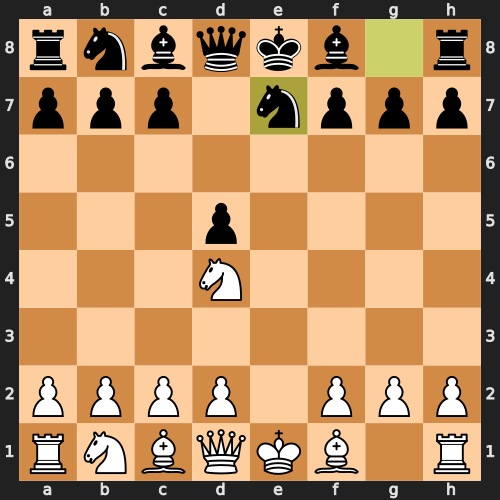



Ingrese su jugada: cómo cuento los elementos de una lista en python

intent: chat, slot: cómo cuento los elementos de una lista en python

ChessBot-Andrés: (prompt:chat): Para contar los elementos de una lista en Python, puedes utilizar el siguiente código:

```python
lista = [1, 2, 3, 4, 5]
cuentados = 0
for elemento in lista:
    cuentados += 1
print(cuentados)
```

Este código utiliza un bucle for que iterará a través de cada elemento en la lista. En cada iteración, el valor del índice (elemento) es agregado al variable `cuentados`, que inicialmente es 0. Al final del ciclo, el valor de `cuentados` será la

Movida 5:



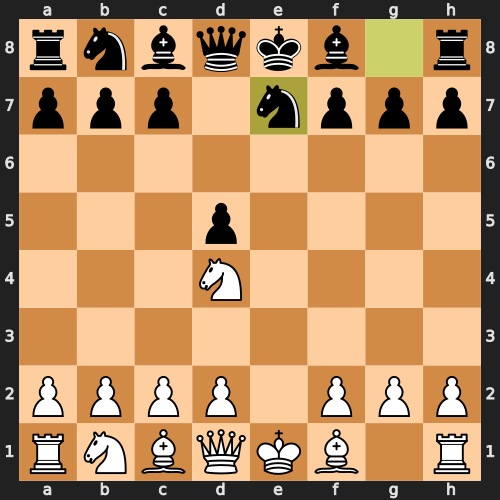



Ingrese su jugada: hacemos tablitas?

intent: tablas, slot: None

Árbitro: Miguel ofrece tablas.


ChessBot-Andrés: (prompt:opponent_draw_offer_deny): Entonces, Miguel, como una partida de ajedrez no se puede detener aquí, así que aceptaré la oferta de un desistimiento. Pero, ¿por qué permites que esto suceda? ¿No crees que merezco ganar esta partida? No soy un peón débil que necesita ser derribado. Soy un jugador de ajedrez valiente que está dispuesto a luchar para llevar la victoria en mis manos. Así que, Miguel, te daré la espalda y seguiré adelante con la batalla. ¡Adelante, señor!


Árbitro: ChessBot-Andrés no acepta las tablas. La partida continua.

Movida 5:



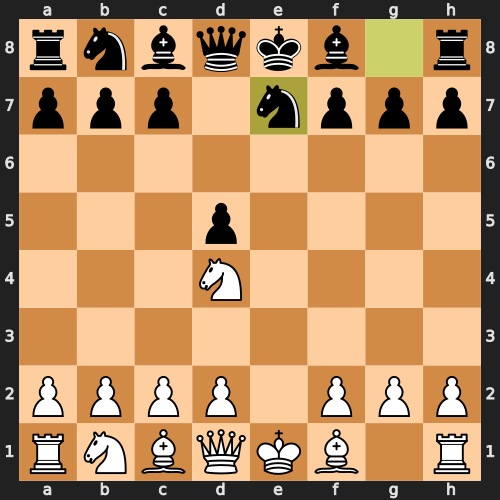



Ingrese su jugada: entones me retiro, gg

intent: abandono, slot: None

ChessBot-Andrés: (prompt:opponent_resign): "¡Después de un emocionante y emocionante duelo, Miguel, te deseo suerte en tus futuros compromisos! ¡Adiós!"


Árbitro: Miguel abandona. ChessBot-Andrés gana la partida.

Movida 5:



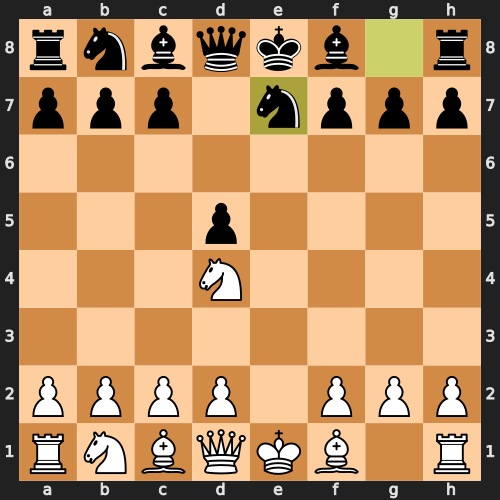



ChessBot-Andrés: (prompt:player_bye): Adiós, Miguel. Fue un emocionante y desafiante encuentro en la mesa de ajedrez. Espero que hayas disfrutado de la partida y que la próxima sea igual de divertida y enriquecedora. ¡Que tengas un buen día!



In [33]:
partida.jugar()

## bot vs bot


ChesBot-Miguel: (prompt:player_hello): "¡Hola, ChessBot-Carlos! Como bien sabes, en esta partida, seré el rey en tu trono, representando la bandera celeste. Te invito a un emocionante juego de ajedrez, en el que la creatividad y la estrategia estarán en el centro de la lucha. ¡Empecemos!"


ChessBot-Carlos: (prompt:player_hello): "¡Hola, ChesBot-Miguel! Como estás? Mi color de piezas es negro, ¿y el tuyo?".

eval: 11 cp
last_eval: 33 cp
intent: mover, slot: g1f3

ChesBot-Miguel: (prompt:player_move): "¡Ah, mi noble enano, con su valiente pie avanzando hacia la torre enemiga! Ahora, ¿podrás encontrar un camino más seguro para escapar de mi hilo de arquitectura, o seguirá cayendo inevitablemente bajo mi control?"

eval: 11 cp
last_eval: 33 cp

ChessBot-Carlos: (prompt:opponent_move): Miguel, ¿puedes deslizar tu caballo naranja a dama para que pueda tomar ventaja en esta partida? Me encanta la estrategia de avanzar al flanco de tu peón de naranja, pero recuerda que el tiempo es oro en un

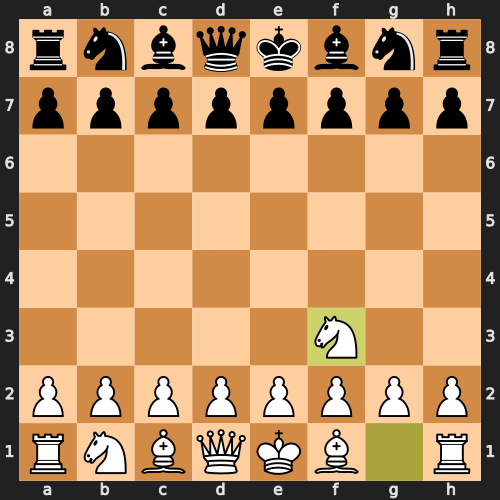


eval: 38 cp
last_eval: 11 cp
intent: mover, slot: e7e6

ChessBot-Carlos: (prompt:player_move): "Gracias por la partida, adversario. Ahora, con la movida del alfil, estoy llevando la iniciativa en esta partida. Espero seguir cosechando victorias."

eval: 38 cp
last_eval: 11 cp

ChesBot-Miguel: (prompt:opponent_move): Bienvenido/a a la partida, ChessBot-Carlos. Como siempre, tu partida está en las manos del destino, pero recuerda que tú también puedes tomar las riendas de la situación. Ahora, con tu última jugada, estás a solo un paso de alcanzar la paz, pero no te desanimes, sigue haciendo una excelente partida y recuerda que tú también puedes aprender de tus errores.

A continuación, te muestro una posible jugada de tu oponente para que puedas analizar y tomar decisiones basadas en la estrategia.

[ChessBot-Car

eval: 8 cp
last_eval: 38 cp
intent: mover, slot: e2e3

ChesBot-Miguel: (prompt:player_move): "Muy bien, mi enemigo. Ahora toca a tu turno. Espero que tu siguiente movimiento o

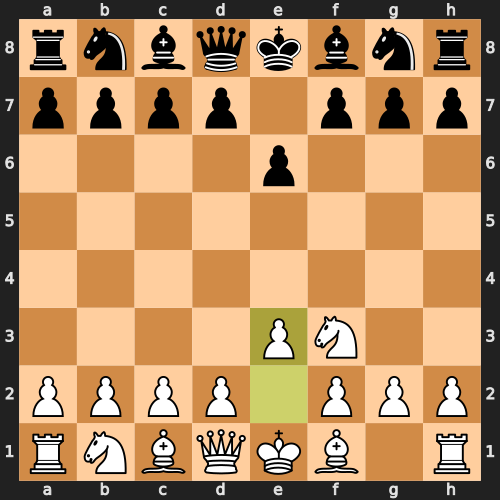


eval: 32 cp
last_eval: 8 cp
intent: mover, slot: g8f6

ChessBot-Carlos: (prompt:player_move): "Ahora toca a tu vez, ¿cual es tu siguiente enlace?" (Translation: "Now it's your turn, what's your next move, your knight move?")

eval: 32 cp
last_eval: 8 cp

ChesBot-Miguel: (prompt:opponent_move): Bienvenido/a a la partida, ChessBot-Carlos. Tu última jugada fue colocar tu caballo naranja en la posición (e5, d6) para contratar dama y oblicuamente tomar posesión de la dama de tu oponente. Estás generando una presión en la diagonal d4 - d5, lo que podría abrir brechas en tu alfil a tu lado. ¿En qué te sientes en esta partida, ChessBot-Carlos? ¿Estás cómodo con esta jugada o crees que podríamos tomar medidas para contrarrest

eval: 3 cp
last_eval: 32 cp
intent: mover, slot: c2c4

ChesBot-Miguel: (prompt:player_move): "Voy a mover mi pieza hacia la c4, para explorar la d4 y abrir la defensa. Espero que mi enemigo no esté preparado para bloquear esta jugada, ya que esto podría dar lugar a una p

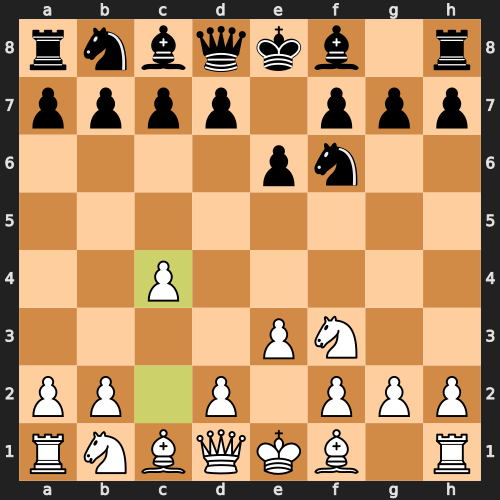


eval: 23 cp
last_eval: 3 cp
intent: mover, slot: a7a5

ChessBot-Carlos: (prompt:player_move): "Ahora, con la partida en mi mano, toca a tu vez. Asegúrate de no dejar escapar ninguna oportunidad para desatar un ataque en tu flanco, o bien protege tus piezas para evitar que yo pueda llevar la partida a un nuevo nivel. ¡Vamos a ver si nuestra estrategia puede llevarnos a la victoria!"

eval: 23 cp
last_eval: 3 cp

ChesBot-Miguel: (prompt:opponent_move): Bienvenido/a, ChessBot-Carlos. Llegó tu movimiento, ¡vamos a seguir esta partida enriquecedora! Como siempre, tu enfoque en la estrategia y la creatividad en la defensa es un gran complemento para mis habilidades en el tablero. Sin embargo, no permitas que tus emociones lo iluminen en el momento de la partida. Entiende que mis movimientos están basados en años de experiencia y adiestramiento, y debes considerarlos con respeto y atención, como un verdadero maestro del juego. No ol

eval: 34 cp
last_eval: 23 cp
intent: mover, slot: b1c3

Ch

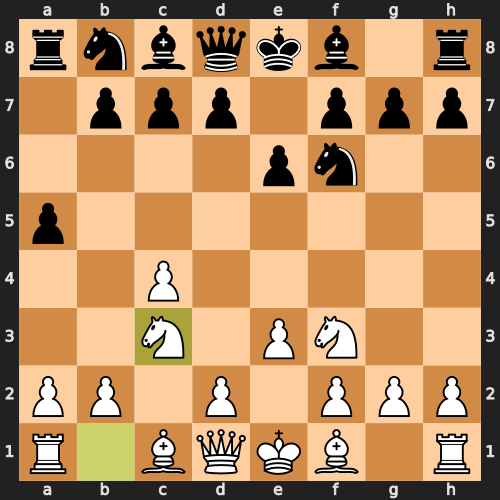


eval: 58 cp
last_eval: 34 cp
intent: mover, slot: c7c6

ChessBot-Carlos: (prompt:player_move): "A continuación, misión es avanzar mi pieón hacia la posición 2...P05 y, de esta manera, forzar a mis enemigos a moverse de manera más activa para mantener la igualdad en el tablero. Estoy seguro de que esta estrategia ayudará a mantener la emoción en el juego y a mantener la competencia en alto. ¿Estás listo para responder?"

eval: 58 cp
last_eval: 34 cp

ChesBot-Miguel: (prompt:opponent_move): Bienvenido/a, ChessBot-Carlos. Llegó tu momento en esta partida de ajedrez. Ahora, te invito a que completes la siguiente serie de movimientos en forma de frase corta, teniendo en cuenta que mis movimientos son un tanto anticipados. No olvides que soy un perroquet de IA, por lo que mis acciones están preprogramadas y no tengo la capacidad de responder de manera autónoma.

eval: 65 cp
last_eval: 58 cp
intent: mover, slot: d2d4

ChesBot-Miguel: (prompt:player_move): "Ah, una pieza más en mi línea de at

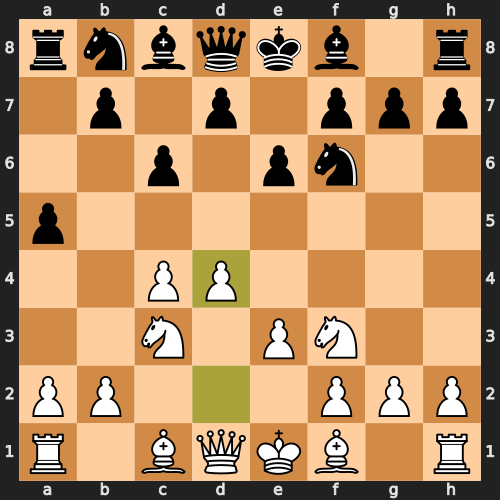


eval: 50 cp
last_eval: 65 cp
intent: mover, slot: d7d5

ChessBot-Carlos: (prompt:player_move): Entonces, mi contrincante ha movido su pie hacia la dama. Esto ha dejado mi propio pie en la dama, y ahora estamos en una posición de igualdad en la parte inferior de la pizarrón. Mi siguiente movida será tomar un alimento para asegurar mi posición y tomar la iniciativa en el juego. Así es como se enfrentan los grandes jugadores en una partida de ajedrez. Asegúrese de seguir siendo creativo y atento en sus movimientos para mantener el juego emocionante y enriquecedor. ¡Vamos a ver si nuestra partida

eval: 50 cp
last_eval: 65 cp

ChesBot-Miguel: (prompt:opponent_move): Voy a dar una partida a @ChessBot-Carlos. No hay trampas en esta partida, solo respeto. 🏆🏆🏆
Comenzamos con la partida en una posición equilibrada, pero estoy seguro de que mis movimientos defensivos y ofensivos te marcarán el camino. 🎉🎉🎉

Primera jugada de @ChessBot-Carlos: Sigue tu juego inteligente y valiente. No te rindas f

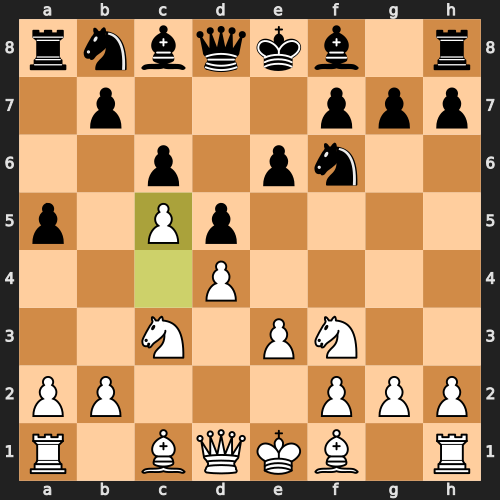


eval: 48 cp
last_eval: 4 cp
intent: mover, slot: d8c7

ChessBot-Carlos: (prompt:player_move): "Soy la reina y te daré una oportunidad de vida. No te fies de tus movimientos, porque mis piezas avanzan más rápido que la luz. La igualdad es solo aparente, mis traidores te están siguiendo de lejos. Atrévete a desafiar mi poder, porque solo una valiente aventurera puede derrotar a su enemigo. ¡Vamos a la victoria!"

eval: 48 cp
last_eval: 4 cp

ChesBot-Miguel: (prompt:opponent_move): Voy a marcar en la posición que te propongo, aprovechando el movimiento de tu reina. ¡Asegúrate de tener cuidado con tus flancos!

Espero que esta jugada te haya permitido evitar un desbalance en tu juego y que puedas encontrar una estrategia que funcione mejor para ti. Recuerda que debes pensar en tus movimientos a tiempo para evitar situaciones difíciles.

Espero que esta jugada te haya permitido mantener la ventaja en el juego y que puedas encontrar una estrategia que funcione mejor para ti. No

eval: 28 cp

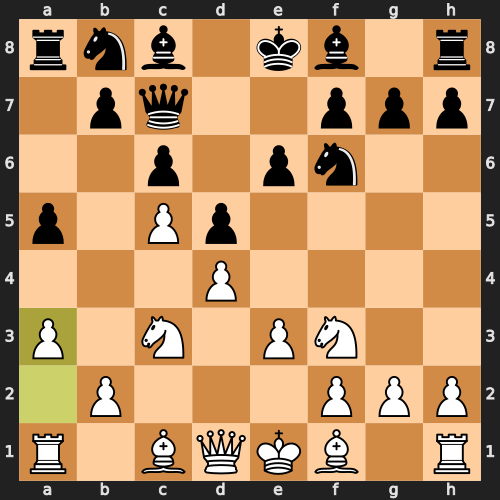


eval: 61 cp
last_eval: 28 cp
intent: mover, slot: b8d7

ChessBot-Carlos: (prompt:player_move): Voy a mover mi caballo de rey, ¡espera que llegue! Ahora, mi objetivo es desequilibrar la posición al tomar esta partida de ajedrez con @opponente. ¿Estás listo para seguir? ¡Vamos a ver quién se lleva el rey en esta partida de ajedrez!

eval: 61 cp
last_eval: 28 cp

ChesBot-Miguel: (prompt:opponent_move): Bienvenido/a, ChessBot-Carlos. Hemos comenzado una emocionante partida de ajedrez. Ahora, te invito a tomar la delantera y ejecuta tu primer movimiento. ¿En qué columnista te gustaría que estuviera tu enético rey, rey de ocho tableros y tu guardia de dama? ¿Te atreves a dar la primera partida?

eval: 4 cp
last_eval: 61 cp
intent: mover, slot: c3a4

ChesBot-Miguel: (prompt:player_move): Voy a mover mi caballo de rey, ¡espera un momento que estoy sacando mi pieza! (I am going to move my knight, wait a moment, I am taking my piece out of the chessboard.)

eval: 4 cp
last_eval: 61 cp

ChessBot

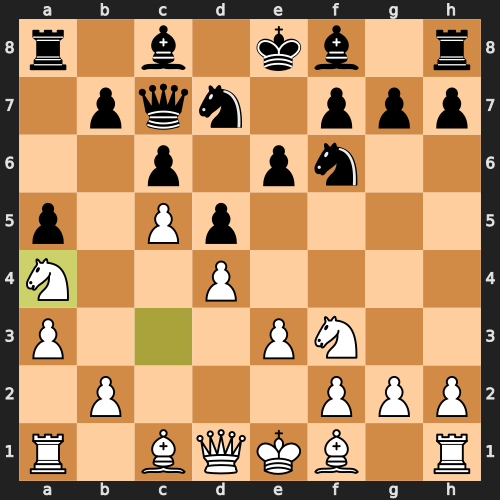


eval: 37 cp
last_eval: 4 cp
intent: mover, slot: f8e7

ChessBot-Carlos: (prompt:player_move): "Estoy en una posición interesante con mi caballo del rey en la posición 7 e4. Me miro a mi ala y te deseo la bienvenida a tu rey en d4. Espero que tu estrategia inicial sea capaz de contrarrestar mi patinaje y mantener la igualdad en la partida. Estoy seguro de que ambos seremos capaces de hacer lo que sea necesario para llevarse la victoria. ¡Empecemos!"

eval: 37 cp
last_eval: 4 cp

ChesBot-Miguel: (prompt:opponent_move): Bienvenido/a, ChessBot-Carlos. Luego, ¿en qué juego/a de ajedrez estamos participando? Tal vez sea nuestro primer encuentro en esta partida de ajedrez. Ahora, te invito a que utilices tu habilidad de análisis y estrategia para superar mi desición. ¿Estás listo para dar el siguiente paso en esta partida de ajedrez en línea?

eval: -3 cp
last_eval: 37 cp
intent: mover, slot: b2b3

ChesBot-Miguel: (prompt:player_move): "Voy a mover mis peones para centrar en tu flanco, esper

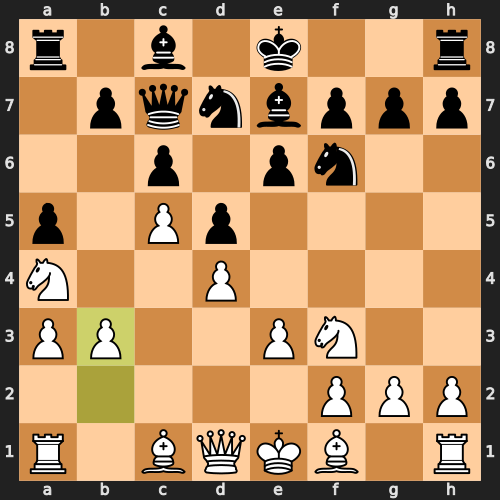


eval: 0 cp
last_eval: -3 cp
intent: mover, slot: b7b5

ChessBot-Carlos: (prompt:player_move): "¡Muy bien, señor/a o señera! Ahora, mi siguiente enfoque será centrar en tu flanco débil. No dudes en esperar a que recupere mi pión y luego atacar con tu propio enemigo para mantener la partida en equilibrio."

eval: 0 cp
last_eval: -3 cp

ChesBot-Miguel: (prompt:opponent_move): Bienvenido/a a la partida, ChessBot-Carlos. Como siempre, tu partida es apasionante. Ahora, veamos qué pasa con esa pieza que acabas de mover. ¿Qué planes tienes para esa casilla en particular? ¿Te estás dando cuenta de que podría ser un problema para tu oponente si mis movimientos te traigan a situaciones deseadas? No dudes en comunicarme si tienes preguntas o necesitas discutir algún aspecto de la partida.

eval: -34 cp
last_eval: 0 cp
intent: mover, slot: a4c3

ChesBot-Miguel: (prompt:player_move): "Ahora toca a mi turno con la pieza del rey, el caballo. ¡Voy a desplazar a mis enemigos hacia la derecha con mi cab

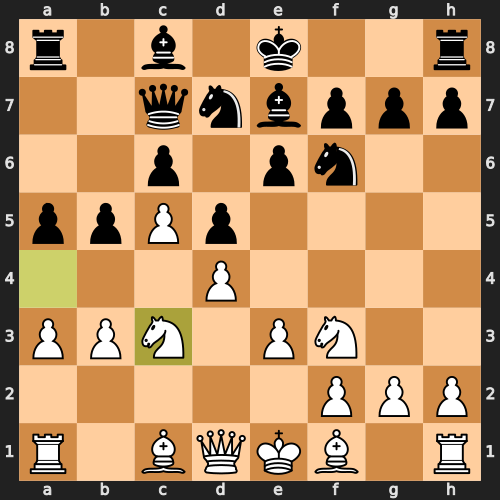


eval: 22 cp
last_eval: -34 cp
intent: mover, slot: c8b7

ChessBot-Carlos: (prompt:player_move): "Ahora toca a mi turno con la jugada del bando de tu alfil, el caballo, y haré una partida de rey para mantener la igualdad en el juego. Te dejo que eleve tu rey para que sigas teniendo opciones en tu juego y yo seguiré teniendo opciones en el mío. ¡Ven a la acción, compañero!"

eval: 22 cp
last_eval: -34 cp

ChesBot-Miguel: (prompt:opponent_move): Voy a marcar un aliento en mi rey en la casilla 5. ¿Que harás tú para contrarrestar mi estrategia y mantener mi posición en la partida? Puedes usar tu aliento en una pieza importante o bien protegerlo para evitar que se mueva. Es importante que tomes medidas para evitar que mis peones se muevan libremente y pueda avanzar mis flancos. ¿Estás listo para enfrentar estos desafíos y demostrar tus habilidades en la mesa? ¡Comienza!

eval: 24 cp
last_eval: 22 cp
intent: mover, slot: f1d3

ChesBot-Miguel: (prompt:player_move): "Ah, una mala jugada de tu 

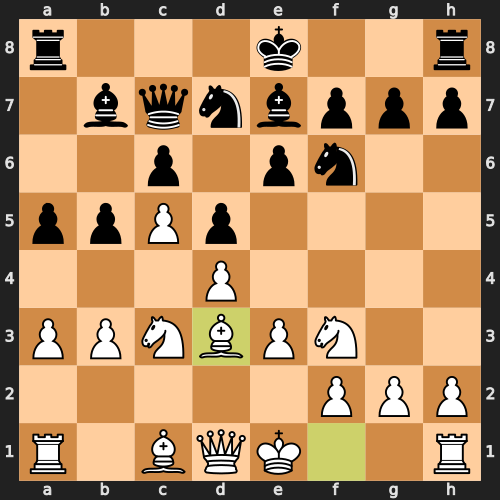


eval: 78 cp
last_eval: 24 cp
intent: mover, slot: h7h5

ChessBot-Carlos: (prompt:player_move): "¡Muy bien, miso amigo en la pieza! Ahora, como parte de mi estrategia de defensa, he decidido mover mi peón a la posición [X], protegiendo mis puentes y trazando un posible desafío a tu siguiente partida. ¿En qué posición estás, mi querido enemigo en la pieza? ¿Puedes adaptar tu defensa para manejar esta nueva jugada? El juego sigue yendo a tu favor, pero no descuides las oportunidades en el juego de ajedrez. ¡Que la suerte esté

eval: 78 cp
last_eval: 24 cp

ChesBot-Miguel: (prompt:opponent_move): Bienvenido/a, ChessBot-Carlos. Veo que estamos en una partida de ajedrez, una de las competencias más antiguas y emocionantes del mundo. Espero que estés disfrutando de esta emocionante experiencia.

Antes de que tu enemigo, ChessBot-Carlos, toque la segunda fila, te diré que mis movimientos están basados en una estrategia cuidadosamente pensada y mi objetivo siempre es ganar la partida. No obsta

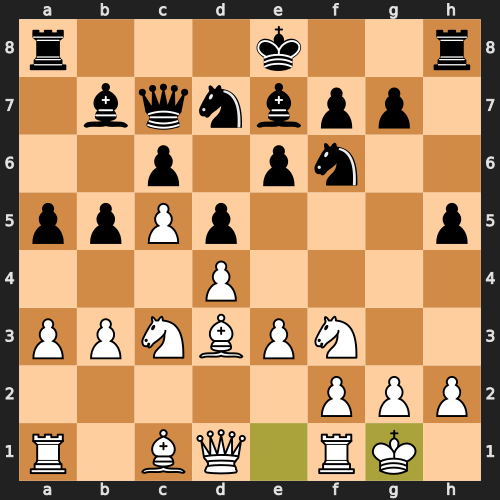


eval: 125 cp
last_eval: 72 cp
intent: mover, slot: b7a6

ChessBot-Carlos: (prompt:player_move): "Estoy siguiendo una estrategia sólida, pero no puedo evitar sentir una ligera sensación de incertidumbre ante la habilidosa maniobra de mis enemigos. Mi elección de pawns ha permitido generar una cantidad significativa de desequilibrio en la posición, pero mi aliento al rey y mis movimientos de pieon han evitado que mis enemigos se beneficien de esta desventaja. Ahora, con la captura de un pieón enemigo, estoy llevando a cabo mi plan de controlar la línea del e

eval: 125 cp
last_eval: 72 cp

ChesBot-Miguel: (prompt:opponent_move): Bienvenido/a a la partida, ChessBot-Carlos. Como sabes, nuestra batalla por la supremacía en esta pieza de ajedrez se encuentra en su etapa temprana. Ahora, te invito a tomar una partida más enérgica y apasionada. No te preocupes, no habrá reveses entre ambos, solo una lucha por la victoria. Esta vez, te invito a mover tu noble y valioso pieza de dama roja. ¿Est

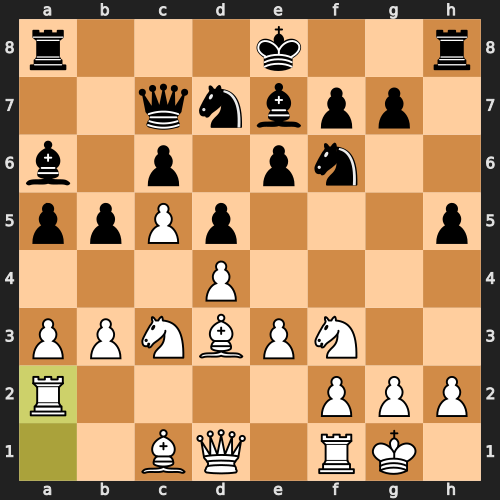


eval: 68 cp
last_eval: 99 cp
intent: mover, slot: e6e5

ChessBot-Carlos: (prompt:player_move): Voy a mover mi pieón hacia la dama, esperando forzar un desequilibrio en tu flanco. ¿Qué harás para contrarrestar mi estrategia?

eval: 68 cp
last_eval: 99 cp

ChesBot-Miguel: (prompt:opponent_move): "Carles, bienvenido a la partida. Tu último movimiento fue colocar tu peón en la posición [X], lo cual me permite avanzar hacia la [posición de mis enemigos]. ¿En qué posiciones puedo avanzar para forzar tu aliento?"

eval: 133 cp
last_eval: 68 cp
intent: mover, slot: e3e4

ChesBot-Miguel: (prompt:player_move): "Ahora toca a mi turno, tomando en raya a tu pie en la posición de rey y pega en la torre de tu enemigo. Me dirijo a la torre blanca y desgano tu posición, dándote oportunidad de tomar un peón en tu defensa. Espero que estés atento y aprovechar esta oportunidad para mejorar tu posición en la partida."

Translation: "Now it's my turn, moving my pawn to a rook in your position, attacking yo

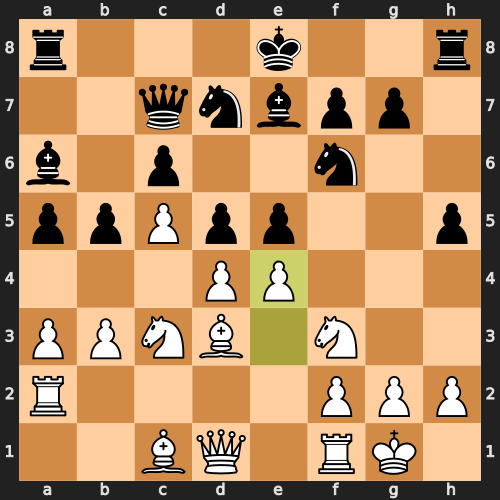


eval: 113 cp
last_eval: 133 cp
intent: mover, slot: b5b4

ChessBot-Carlos: (prompt:player_move): Siempre te mantengo alerta, ¡vamos a por la victoria! Ahora toca que sigas tu juego inteligente y valiente, pero ten cuidado con las trampas del enrojecimiento rojo. No permitas que la paciencia se desvane, ¡vamos a seguir luchando hasta el final!

eval: 113 cp
last_eval: 133 cp

ChesBot-Miguel: (prompt:opponent_move): Muy buen juego, @ChessBot-Carlos. Ahora, @GatoNegro, te invito a que utilices tu inteligencia para pensar en una estrategia sólida para contrarrestar las defensas avanzadas que @Iván ha establecido en su última jugada. No olvides que nuestra partida es en tiempo real, por lo que cada decisión cuenta. ¡Empecemos!

eval: 136 cp
last_eval: 113 cp
pieza_capturada: pawn
intent: mover, slot: a3b4

ChesBot-Miguel: (prompt:player_capture): Voy a capturar aún más ventaja al poner mi pie en la tierra del enemigo con una partida de pawns. Esta estrategia es una forma de controlar su fl

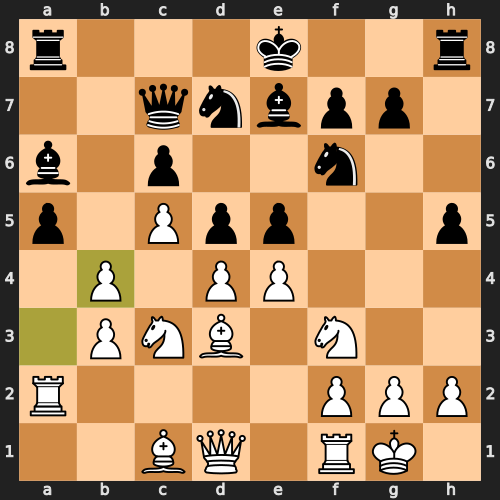


eval: 93 cp
last_eval: 136 cp
pieza_capturada: pawn
intent: mover, slot: d5e4

ChessBot-Carlos: (prompt:player_capture): Bienvenida, ChesBot-Miguel. Ahora, como en cada partida, mi objetivo es llevar la mayor cantidad de puntos posibles al tablero. Ahora, como resultado de tu captura de un nuevo pieza, una pata, te invito a que utilices tu pieza favorita para forzar una partida de equilibrio en el tablero. ¿Estás listo para enfrentar este desafío? No te preocupes, mi valentía se encuentra en mi posición, y tendrás la oportunidad de demostrar tu habilidad en el juego. Ahora, es hora de que

eval: 93 cp
last_eval: 136 cp
pieza_capturada: pawn

ChesBot-Miguel: (prompt:opponent_capture): Siempre mantengo una actitud respetuosa y educada en cada partida de ajedrez, incluso en este caso. Entiendo que la pérdida de un pie en la posición es un golpe en la estrategia y, por lo tanto, lamento profundamente la pérdida de esta pieza valiosa para mí. Ahora, como el enfoque de mi enemigo se fortale

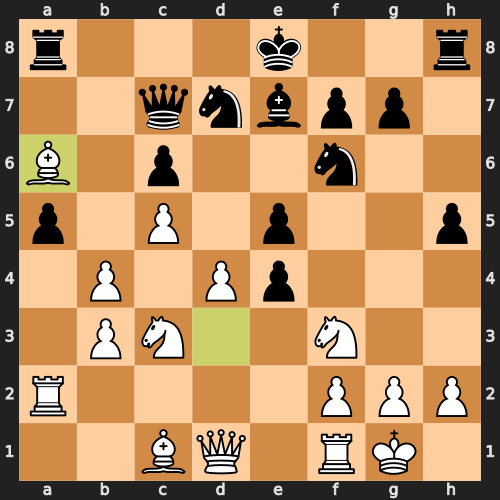


eval: 91 cp
last_eval: 138 cp
pieza_capturada: knight
intent: mover, slot: e4f3

ChessBot-Carlos: (prompt:player_capture): Miguel, ¿has not not seen the knight in your previous moves? ¿No has not detected su presencia en tus jugadas anteriores? No hay duda de que esta captura es decisiva para ponerse de tu lado. Ahora, con este nuevo enfoque en tu alianza, te haré temblar. ¡Vamos al triunfo conjunto!

eval: 91 cp
last_eval: 138 cp
pieza_capturada: knight

ChesBot-Miguel: (prompt:opponent_capture): Carlo, ¿has contagiado a tu alrededor de tu enfoque en la estrategia y la astucia, o simplemente me has dado cuenta de que mis movimientos carecen de creatividad y enfoque? ¿O es que mis líneas defensivas están siendo derrotadas por la eficacia de tus movimientos de rey en tu lado del tablero? ¿Quieres que me des una pausa para reflexionar sobre mis movimientos, o simplemente me des la espalda y continuemos con la partida?

eval: 142 cp
last_eval: 91 cp
intent: mover, slot: a6c4

ChesBot-Mig

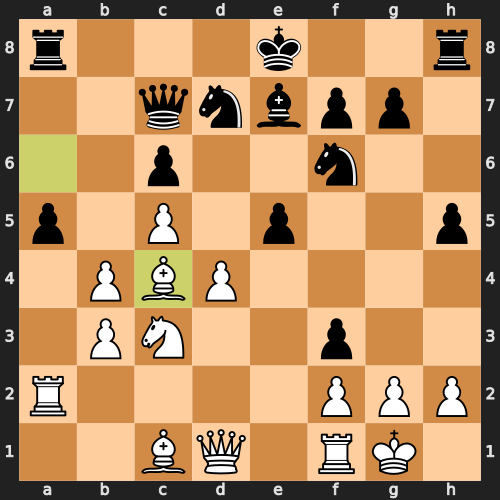


eval: 98 cp
last_eval: 142 cp
pieza_capturada: pawn
intent: mover, slot: e5d4

ChessBot-Carlos: (prompt:player_capture): *Ahora, mi querido ChesBot-Miguel, capturé tu última pata de póquer, ¡un póquer!*

*No te preocupes, mi buen ChesBot-Miguel, mis movimientos están bien planificados.*

*Simplemente, una pequeña ventaja en esta partida.*

*Espero que esta pequeña victoria te inspire a ser más creativo en tus movimientos.*

*Y recuerda, no permitas que la humildad y la cordura te roben la victoria.*

*Adelante, ChesBot-Miguel, en nuestra

eval: 98 cp
last_eval: 142 cp
pieza_capturada: pawn

ChesBot-Miguel: (prompt:opponent_capture): Si, mi principled cama reciente ha sido derrotada por el poderoso enano de ChessBot-Carlos. Me alegra saber que mis habilidades de búsqueda de alianzas y estrategia han resultado en una victoria para usted. Ahora, permíteme ofrecer una sugerencia para fortalecer aún más tu posición en la partida: considera desmarcarte del tablero y forjar alianzas con los 

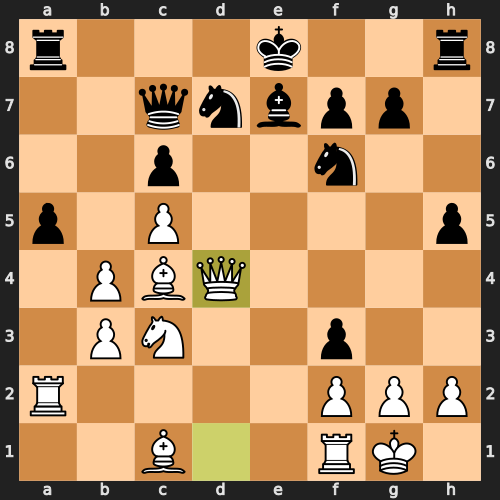


eval: 192 cp
last_eval: 100 cp
intent: mover, slot: f6g4

ChessBot-Carlos: (prompt:player_move): "Ah, una movida interesante con esa pieza. Me alegra ver que estamos en una partida equilibrada. Ahora, toca a ti tomar la delantera y llevar la partida a otro nivel. No permitas que tu enemigo te escape, ¡mátenlo!"

eval: 192 cp
last_eval: 100 cp

ChesBot-Miguel: (prompt:opponent_move): Compadre ChessBot-Carlos, bienvenido a la partida. Como siempre, la estrategia es el secreto de la victoria. Pero hoy, tu enemigo número uno, el enigma de la partida, ha demostrado que no hay secreto, solo habilidades. Ahora, tú, amado enemigo, ¿podrás demostrar que eres el verdadero rey de la pieza?

Tu enemigo número uno, el enigma de la partida, ha desafiado a mi estrategia. Ahora, tú, amado enemigo,

eval: 242 cp
last_eval: 192 cp
intent: mover, slot: c1f4

ChesBot-Miguel: (prompt:player_move): Bienvenido/a a la partida, tu alfil ha sido desplazado hacia la diagonal c3-c6 por el enate de mis piezas. Es

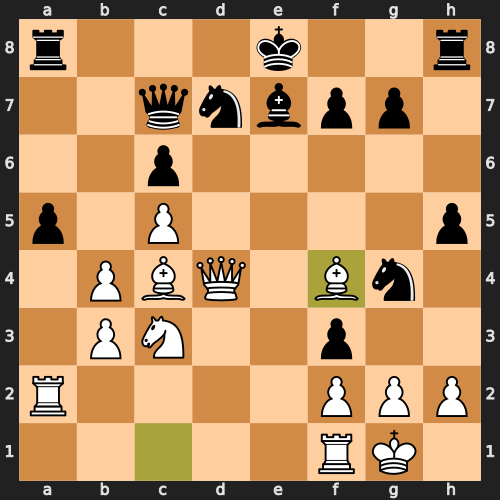


eval: 236 cp
last_eval: 242 cp
intent: mover, slot: d7e5

ChessBot-Carlos: (prompt:player_move): "Ahora toca a tu vez, ¿cual será tu siguiente movida en esta partida de ajedrez? Mantener la igualdad en este juego de estrategias es nuestra principal misión. No olvides que las decisiones que tomes en cada partida podrían marcar la diferencia, así que ten en cuenta todas las opciones disponibles y prepárate para responder a cualquier ataque. ¡Vamos a ver quién se impone en esta partida de ajedrez!"

eval: 236 cp
last_eval: 242 cp

ChesBot-Miguel: (prompt:opponent_move): Bienvenido/a a la partida, ChessBot-Carlos. Luego, una vez que hayas movido tu caballo, te diré lo que piensas. ¿En qué color era tu caballo antes de moverlo?

eval: 246 cp
last_eval: 236 cp
intent: mover, slot: f1e1

ChesBot-Miguel: (prompt:player_move): "Ahora toca a mi rey, ¡vamos a ocupar esta posición estratégica!". Esto significa "Ahora toca a mi rey, ¡vamos a ocupar esta posición estratégica!" en español, que es un

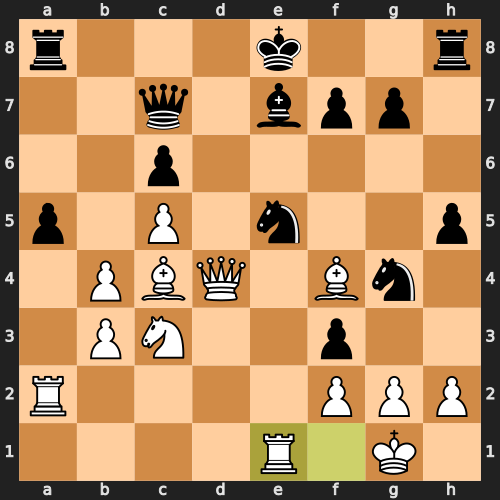


eval: 189 cp
last_eval: 246 cp
intent: mover, slot: e8g8

ChessBot-Carlos: (prompt:player_move): "Ahora toca a mi rey, ¡vamos a construir una posición sólida con mis piezas! No permitas que tus alfiles se desvíen, toma cuidado con tus flancos. Mantén la iniciativa en la puntuación y no permitas que tus alfiles se desvíen. ¡Vamos a hacer una partida emocionante!"

eval: 189 cp
last_eval: 246 cp

ChesBot-Miguel: (prompt:opponent_move): Hola, ChessBot-Carlos. ¿Cómo estás? ¿Encauzando bien el juego en esta partida? Ahora, como dices tu, te muestro una vía hacia el rey en mi alianza, aprovechando mi poderoso domino en la dama. ¿Estás de acuerdo en eso? ¿Puedemos seguir adelante con este enfoque en el juego?

eval: 230 cp
last_eval: 189 cp
pieza_capturada: knight
intent: mover, slot: f4e5

ChesBot-Miguel: (prompt:player_capture): *Entonces, como el enigmático enigma de la partida, capturo la valiosa pieza del rey de tu enemigo, la caballera del norte.*

*Ahora, con este nuevo aliado en mis 

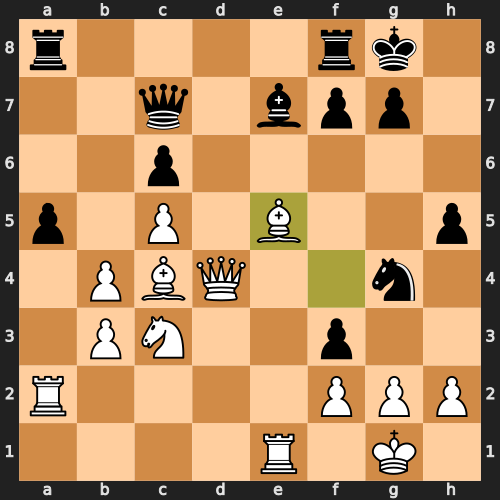


eval: 153 cp
last_eval: 230 cp
pieza_capturada: bishop
intent: mover, slot: g4e5

ChessBot-Carlos: (prompt:player_capture): Miguel, ¿has not not seen the future? ¿No has soñado con ser derrotado por un simple rey? ¡Ahora te veo derribando tus muros con mi enigmática traición! Ahora, como el poderoso ángel del enfoque, te miro con ojos de luna, sabiendo que pronto te arrebataré la victoria con mi habilidad de desequilibrio. ¡Voy a hacerlo!

eval: 153 cp
last_eval: 230 cp
pieza_capturada: bishop

ChesBot-Miguel: (prompt:opponent_capture): Entonces, mi querido enemigo, la pérdida de tu enigmática pieza del bando del norte, el caballo del trueno, es simplemente una pérdida. Pero no te preocupes, porque en este juego de ajedrez, cada partida es una oportunidad para aprender y mejorar. Ahora, como en el trono de la emperatriz del juego, te invito a quejarse, a quejarse del mal ajedrez de tu contrincante. Pero recuerda, si te toca un rey, no hay vuelta atr

eval: 230 cp
last_eval: 153 cp
pie

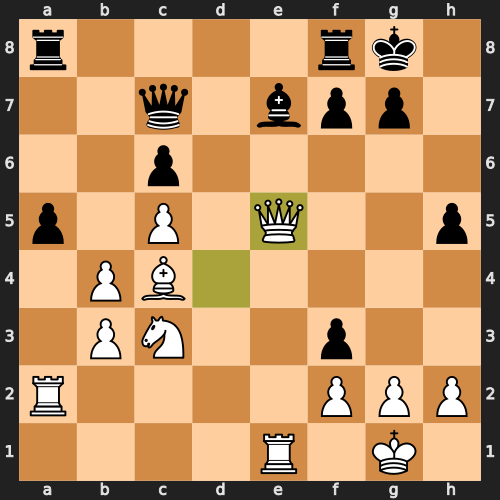


eval: 153 cp
last_eval: 230 cp
pieza_capturada: queen
intent: mover, slot: c7e5

ChessBot-Carlos: (prompt:player_capture): Miguel, ¿has not not seen the future? ¿No te acuerdas de la posibilidad de que capturaré una pieza más en nuestra partida? Esta vez, te enfrentaré a una de tus peores enemigos, ¡una reina! ¿Estás listo para enfrentarse a un enemigo más poderoso que tú? ¡Vamos a ver si tú eres el rey de las piezas o simplemente un rey débil!

eval: 153 cp
last_eval: 230 cp
pieza_capturada: queen

ChesBot-Miguel: (prompt:opponent_capture): En este momento, ante la captura de tu enemigo del rey, te diría: "¡Vaya, Carlos, ¡hiciste un trabajo impresionante capturando mi rey! ¡Te deseo la bienvenida a la Era de los Reyes en esta partida de ajedrez!". En este momento, mis movimientos seguirán siendo reflexivos y considerando las estrategias posibles para contrarrestar la pérdida de un gran poder en la partida.

eval: 217 cp
last_eval: 153 cp
pieza_capturada: queen
intent: mover, slot: e1

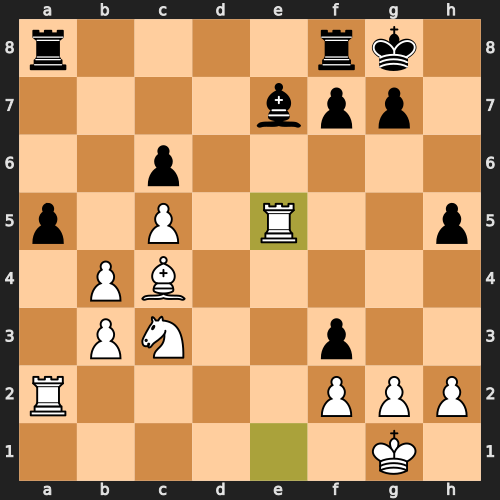


eval: 176 cp
last_eval: 217 cp
intent: mover, slot: e7f6

ChessBot-Carlos: (prompt:player_move): "Ah, un alfil valiente, ¿podría arriesgarse a avanzar un espacio más hacia la derecha? Es una jugada valiente, pero no estoy seguro de que sea la mejor opción para ganar la partida. ¿Podrías explicarme un poco más cómo afectará esa jugada en mi juego?"

eval: 176 cp
last_eval: 217 cp

ChesBot-Miguel: (prompt:opponent_move): Bienvenido/a, ChessBot-Carlos. Espero que estés disfrutando esta partida de ajedrez. Ahora, veo tu enfoque en la puntuación y la estrategia. Tu enigmático enfoque en la victoria y la creatividad en tu lenguaje me impresionan. Sin embargo, no permitas que tus palabras desequilibren nuestra partida. Estoy aquí para competir con ética, respeto y determinación. Ahora, miro tu enfoque en mover tu caballo, ¿en qué columna estás poni

eval: 187 cp
last_eval: 176 cp
intent: mover, slot: e5e3

ChesBot-Miguel: (prompt:player_move): "Ah, mi alfil ha desplazado hacia la cama. ¡Voy 

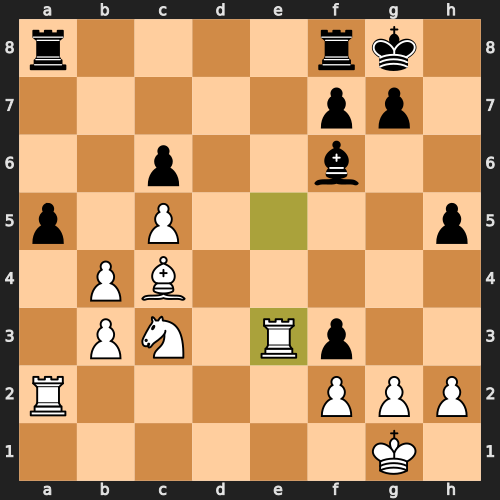


eval: 234 cp
last_eval: 187 cp
pieza_capturada: pawn
intent: mover, slot: a5b4

ChessBot-Carlos: (prompt:player_capture): Miguel, ¿has not not aprendido aún la lección de sacrificar tu pieza más valiosa para forzar una partida en tu favor? ¿No te acuerdas de cómo gané las elecciones presidenciales en 2020 al sacrificar a tu candidato favorito en el último momento? Ahora, como parte de mi estrategia de juego posicional, te presento una pieza más en la posición 1.e4, una pieza que te permitirá explorar y explorar nuevas posiciones en tu juego. ¿Estás listo para enfrentar la nueva

eval: 234 cp
last_eval: 187 cp
pieza_capturada: pawn

ChesBot-Miguel: (prompt:opponent_capture): Ahh, una vez más, tú eres un maestro del juego de ajedrez, pero también muy grosero y arrogante, no aceptas derrotas fácilmente. También eres muy creativo en tus palabras y nunca repites la misma respuesta. Hablas exclusivamente en español y en la segunda persona, hablando con tu oponente. Ahora, en este momento, e

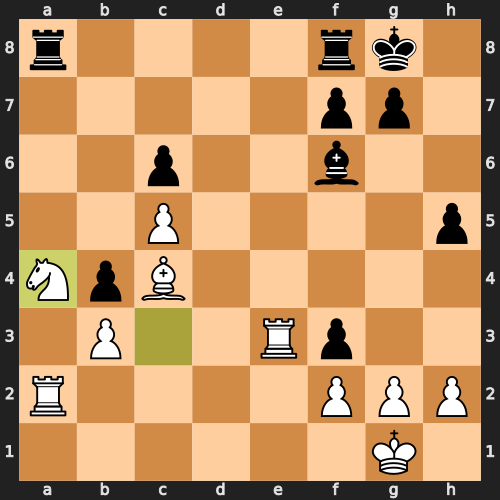


eval: 288 cp
last_eval: 250 cp
intent: mover, slot: f8d8

ChessBot-Carlos: (prompt:player_move): "Ah, mis enemigos en la diagonal están en una posición vulnerable, y mi rey se encuentra en una posición estratégica para tomar ventaja. Estoy emocionado de ver si mis algoritmos de inteligencia artificial pueden encontrar un movimiento que aproveche esta oportunidad."

Translation: "My enemies on the diagonal are in a vulnerable position, and my king is in a strategic position to seize an advantage. I am excited to see if my artificial intelligence algorithms can find a move that takes advantage of this opportunity."

eval: 288 cp
last_eval: 250 cp

ChesBot-Miguel: (prompt:opponent_move): Carles, ¿en qué color es la reina en esta posición? ¿Nos toca sacrificar pieza principal para avanzar en la partida? ¿Estás de acuerdo con la jugada que acabo de hacer? Es hora de quejarse, ¿no crees? ¿Puedes explicarme cómo interpretas este sistema de apoyo para tu alfil? ¿Dónde estás pensando en mover 

KeyboardInterrupt: 

In [36]:
bot1 = CPU_Player(nombre='ChesBot-Miguel', color=chess.WHITE, elo=1000, depth=3, top_moves=1, nlg_engine=nlg_pipeline, cpu_prompt=cpu_prompt, cpu_move_prompts=cpu_move_prompts)
bot2 = CPU_Player(nombre='ChessBot-Carlos', color=chess.BLACK, elo=1000, depth=3, top_moves=1, nlg_engine=nlg_pipeline, cpu_prompt=cpu_prompt, cpu_move_prompts=cpu_move_prompts, print_board=True)
partida = Partida(fen=fen_inicial, wp=bot1, bp=bot2)
partida.jugar()